## Requirements

In [1]:
#! pip install pytorch-forecasting==0.8.3
#! pip install pytorch-lightning==1.1.8
#! pip install missingno

# Temporal Fusion Transformer 

### Introduction
- https://arxiv.org/pdf/1912.09363.pdf
- PyTorch implementation with example: https://pytorch-forecasting.readthedocs.io/en/latest/tutorials/stallion.html
- Other implementations: https://paperswithcode.com/paper/temporal-fusion-transformers-for 

#### Key features
- multi-horizon
- different types of covariates
- attention based model 

In [2]:
import copy
from pathlib import Path
import warnings

import numpy as np
import pandas as pd
import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor
from pytorch_lightning.loggers import TensorBoardLogger
import torch

from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.metrics import SMAPE, QuantileLoss
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters
import missingno as msno

## Loading data

In [4]:
data = pd.read_csv('final_10k_sun_data.zip') #data = pd.read_csv('ra-data.csv')
data.rename(columns={"azimuth.1": "sun_azimuth"}, inplace=True)

In [5]:
pd.set_option('display.max_columns', None)

In [6]:
# add time index
data['year'] = pd.to_datetime(data['measure_time']).dt.year
data['hour'] = pd.to_datetime(data['measure_time']).dt.hour
data['date'] = pd.to_datetime(data['measure_time']).dt.date
data['month'] = pd.to_datetime(data['measure_time']).dt.month

In [7]:
indexes = data['panel_id'].value_counts().where(lambda x: x==33600).dropna().index.to_list()
#indexes = data['panel_id'].value_counts().index.to_list()

In [8]:
data = data[data['panel_id'].isin(indexes)]

In [9]:
data['dayofyear'] = pd.to_datetime(data['measure_time']).dt.dayofyear
data["time_idx"] = data['year'] * 365 * 24 + (data["dayofyear"] * 24) + data['hour']
data["time_idx"] -= data["time_idx"].min()

In [10]:
#data.drop(['Unnamed: 0'], 1, inplace=True)

In [11]:
data = data.drop_duplicates()

In [12]:
#msno.matrix(data)

In [13]:
#data = data[(data.year > 2019)]

In [14]:
data.drop(['measure_time', 'city', 'date'], 1, inplace=True)
#data.drop(['temperature', 'wind_speed', 'surface_thermal_radiation'], 1, inplace=True)

In [15]:
data['panel_id'] = data['panel_id'].astype(str)
data['month'] = data['month'].astype(str)
data['year'] = data['year'].astype(str)
data['hour'] = data['hour'].astype(str)
data['dayofyear'] = data['dayofyear'].astype(str)

In [16]:
data.reset_index(drop=True, inplace=True)

## Preprocess data

In [17]:
max_prediction_length = 96 # last N samples will be excluded from training, we can use those samples for backtesting etc
max_encoder_length = 100
training_cutoff = data["time_idx"].max() - max_prediction_length

training = TimeSeriesDataSet(
    data[lambda x: x.time_idx <= training_cutoff],
    time_idx="time_idx",
    target="production_w",
    group_ids=['panel_id'],  # keep encoder length long (as it is in the validation set)
    max_encoder_length=max_encoder_length,
    min_prediction_length=1,
    max_prediction_length=max_prediction_length,
    static_categoricals=["panel_id"], # fill with the data if categorical
    static_reals=["tilt",'azimuth', 'longitude', 'latitude'], # fill with numeric data
    time_varying_known_categoricals=['month','hour', 'year', 'dayofyear'],
    #variable_groups={"special_days": special_days},  # group of categorical variables can be treated as one variable
    time_varying_known_reals=['time_idx','altitude', 'sun_azimuth'],
    #time_varying_unknown_categoricals=[],
    time_varying_unknown_reals=['production_w', 
                                'surface_direct_solar_radiation', 
                                'surface_diffuse_solar_radiation', 
                                'temperature',
                                'wind_speed',
                                'surface_thermal_radiation'
                               ],
    #target_normalizer=GroupNormalizer(
    #    groups=["ticker"], transformation="softplus"
    #),  # use softplus and normalize by group
    add_relative_time_idx=True,
    add_target_scales=True,
    add_encoder_length=True,
    allow_missings=True
)

# create validation set (predict=True) which means to predict the last max_prediction_length points in time
# for each series
validation = TimeSeriesDataSet.from_dataset(training, data, predict=True, stop_randomization=True)

# create dataloaders for model
batch_size = 128 # set this between 32 to 128
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=4)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size * 10, num_workers=4)

In [18]:
# calculate baseline mean absolute error, i.e. predict next value as the last available value from the history
actuals = torch.cat([y for x, (y, weight) in iter(val_dataloader)])
baseline_predictions = Baseline().predict(val_dataloader)
(actuals - baseline_predictions).abs().mean().item()

454.9346008300781

## Training 

In [19]:
# configure network and trainer
pl.seed_everything(42)
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=30, verbose=False, mode="min")
lr_logger = LearningRateMonitor()  # log the learning rate
logger = TensorBoardLogger("lightning_logs")  # logging results to a tensorboard


# study = optimize_hyperparameters(
#         train_dataloader,
#         val_dataloader,
#         model_path="optuna_test",
#         n_trials=4,
#         max_epochs=50,
#         gradient_clip_val_range=(0.01, 1.0),
#         hidden_size_range=(8, 128),
#         hidden_continuous_size_range=(8, 128),
#         attention_head_size_range=(1, 4),
#         learning_rate_range=(0.001, 0.1),
#         dropout_range=(0.1, 0.3),
#         trainer_kwargs=dict(limit_train_batches=30),
#         reduce_on_plateau_patience=4,
#         use_learning_rate_finder=True,  # use Optuna to find ideal learning rate or use in-built learning rate finder
# )

# optimzed_training_params = study.best_trial.params

trainer = pl.Trainer(
    max_epochs=40,
    gpus=1,
    weights_summary="top",
    gradient_clip_val=0.1,#optimzed_training_params['gradient_clip_val'],
    limit_train_batches=25,  # coment in for training, running valiation every 30 batches
    #fast_dev_run=True,  # comment in to check that networkor dataset has no serious bugs
    callbacks=[lr_logger, early_stop_callback],
    logger=logger
)


tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=0.03,#optimzed_training_params['learning_rate'],
    hidden_size=16, #optimzed_training_params['hidden_size'],
    attention_head_size=2,#optimzed_training_params['attention_head_size'],
    dropout=0.3,# optimzed_training_params['dropout'],
    hidden_continuous_size=8,# optimzed_training_params['hidden_continuous_size'],
    output_size=20,  # 7 quantiles by default
    loss=QuantileLoss(),
    log_interval=10,  # uncomment for learning rate finder and otherwise, e.g. to 10 for logging every 10 batches
    reduce_on_plateau_patience=4,
)
#print(vars(tft))
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")


# fit network
trainer.fit(
    tft,
    train_dataloader=train_dataloader,
    val_dataloaders=val_dataloader,
)

Global seed set to 42
GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Number of parameters in network: 36.2k



   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 6.3 K 
3  | prescalers                         | ModuleDict                      | 272   
4  | static_variable_selection          | VariableSelectionNetwork        | 4.5 K 
5  | encoder_variable_selection         | VariableSelectionNetwork        | 8.0 K 
6  | decoder_variable_selection         | VariableSelectionNetwork        | 3.2 K 
7  | static_context_variable_selection  | GatedResidualNetwork            | 1.1 K 
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 1.1 K 
9  | static_context_initial_cell_lstm   | GatedResidualNetwork            | 1.1 

Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

1

## Load and test model

304.4215393066406


/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/pytorch_forecasting/models/base_model.py:566: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).



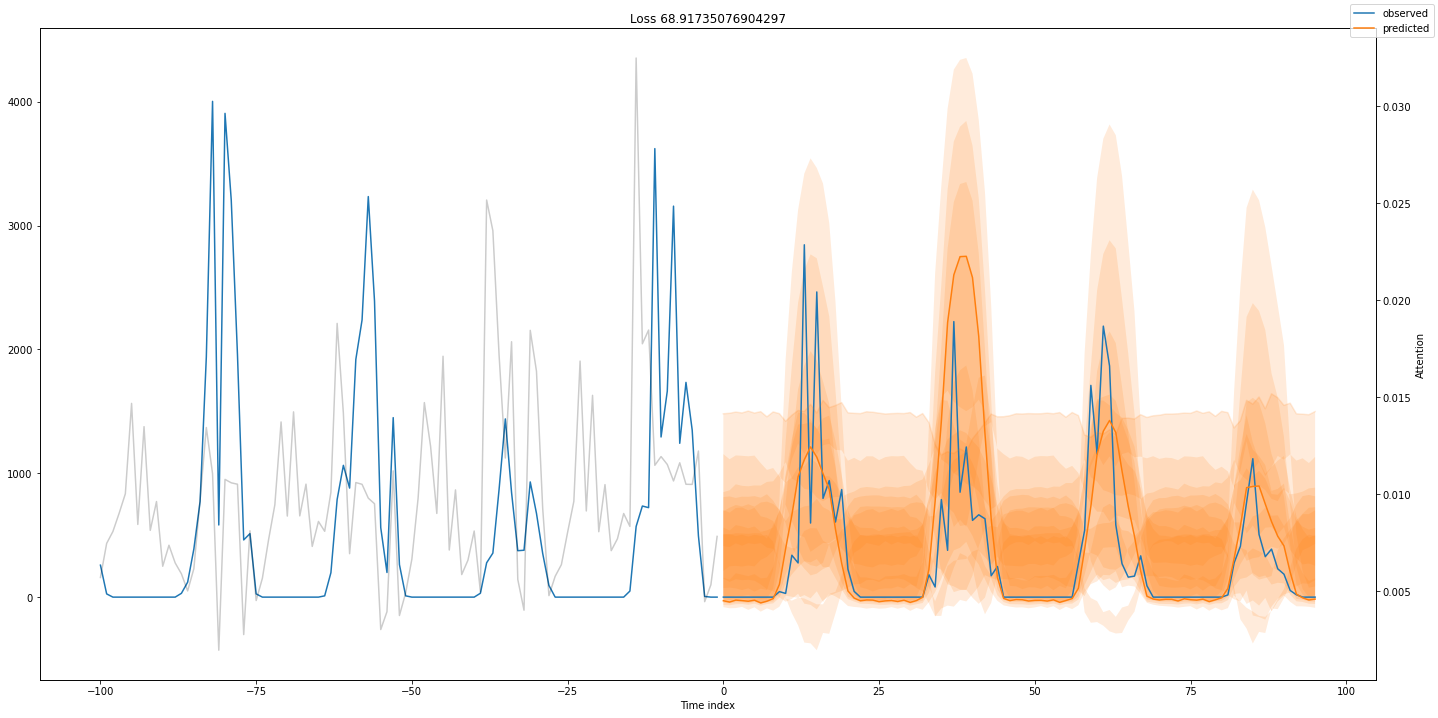

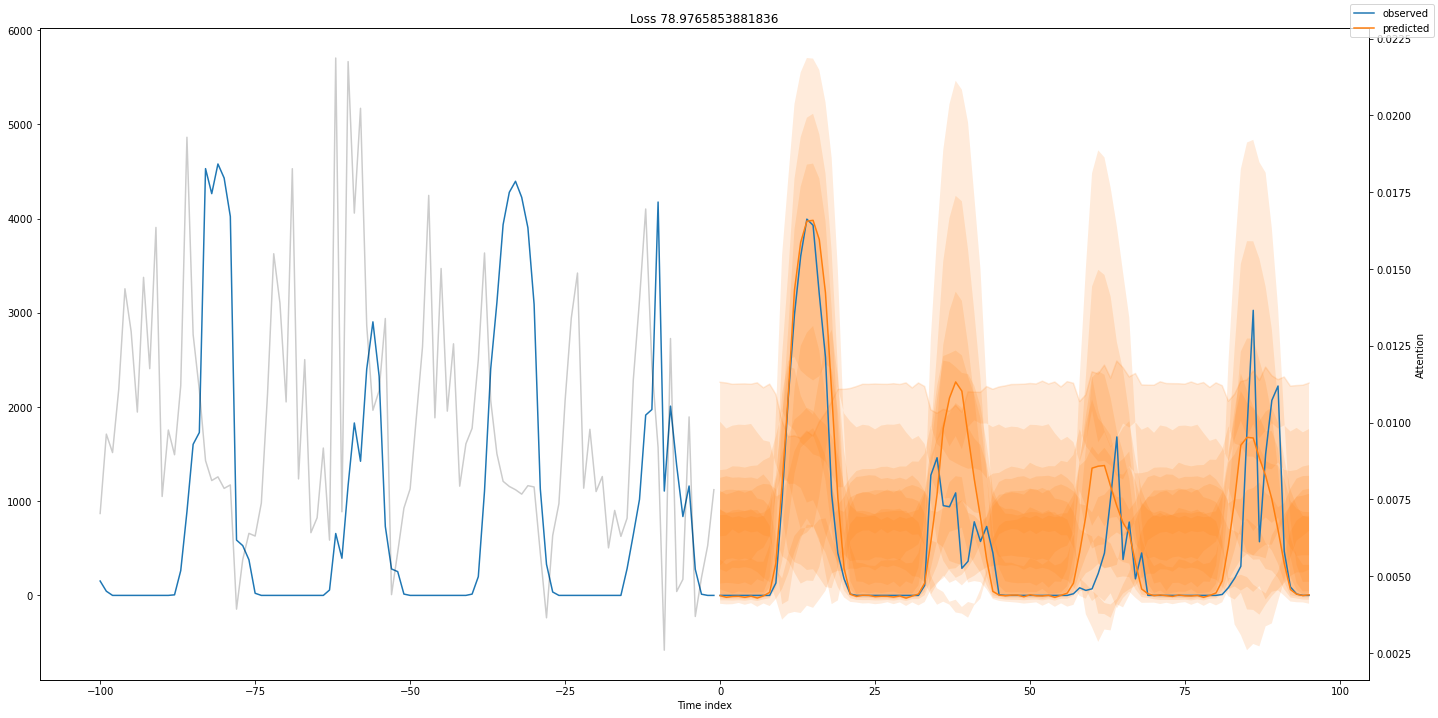

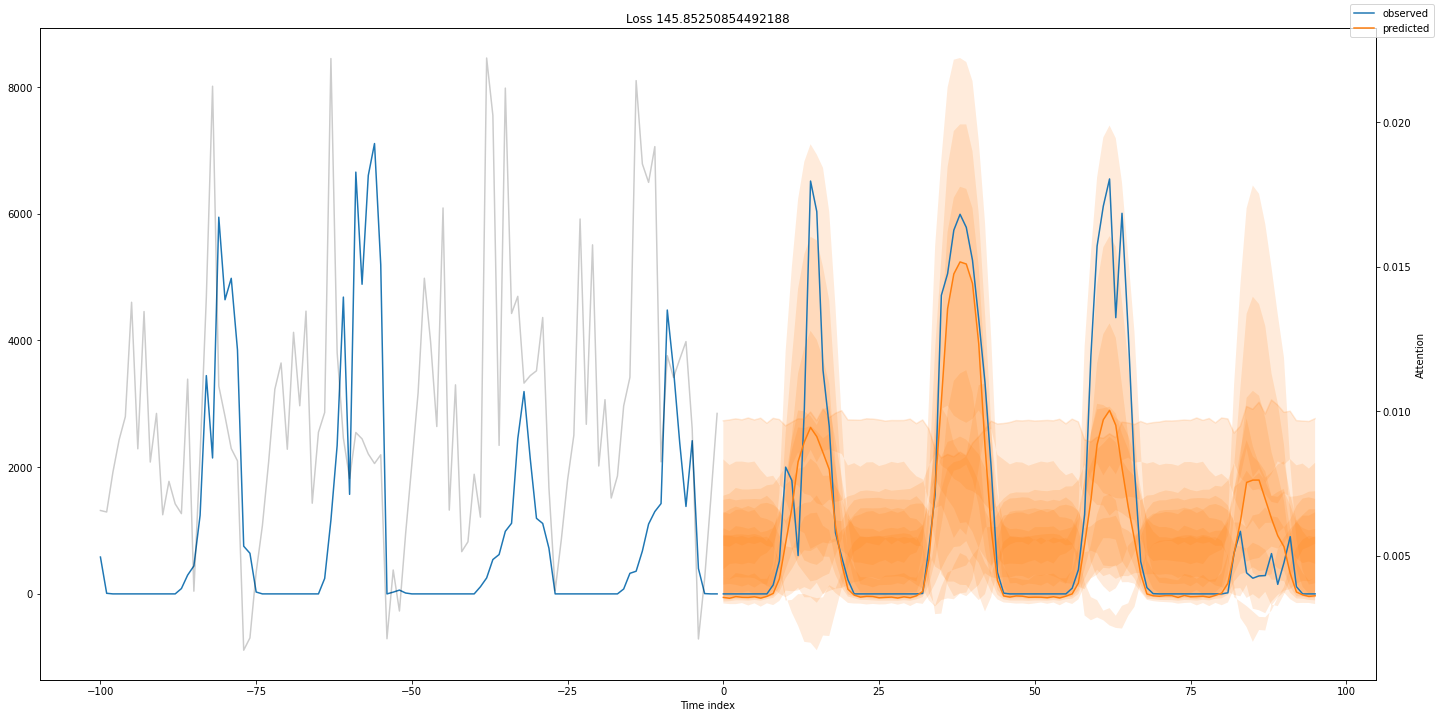

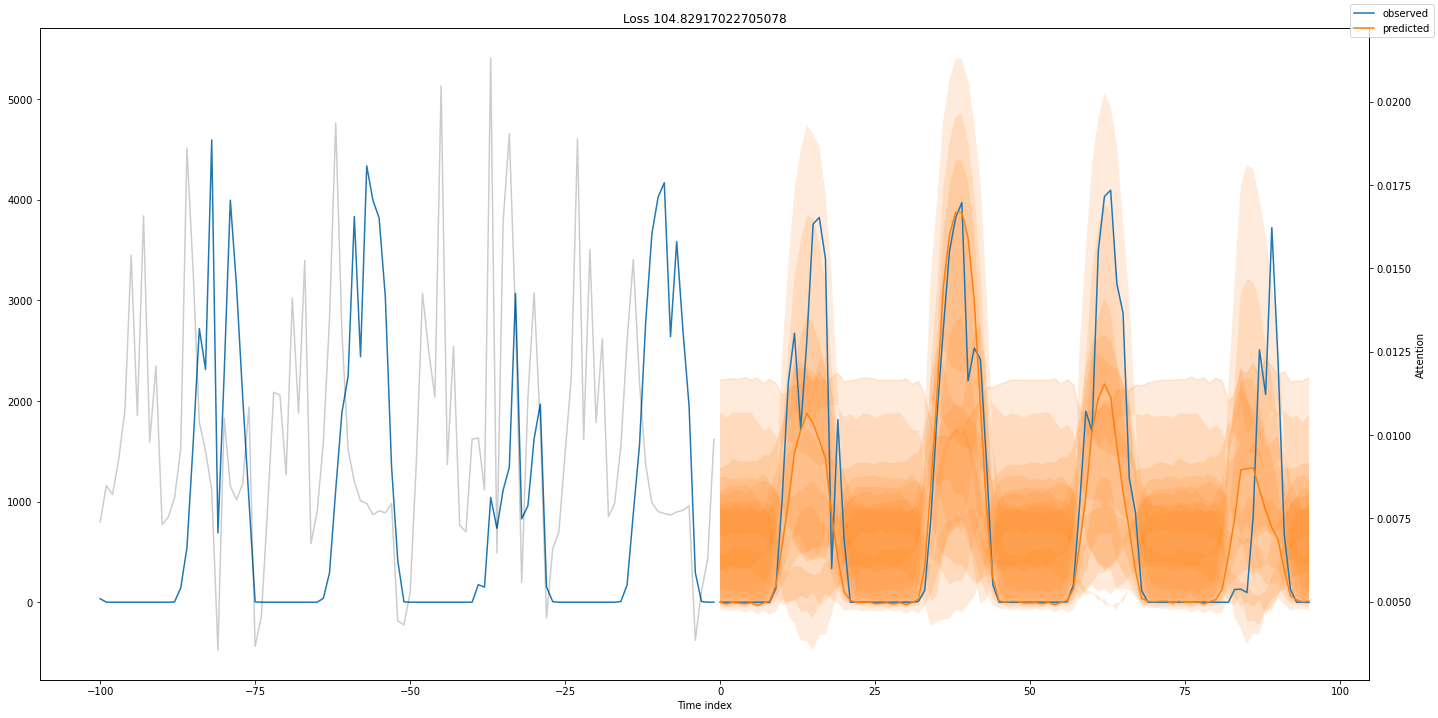

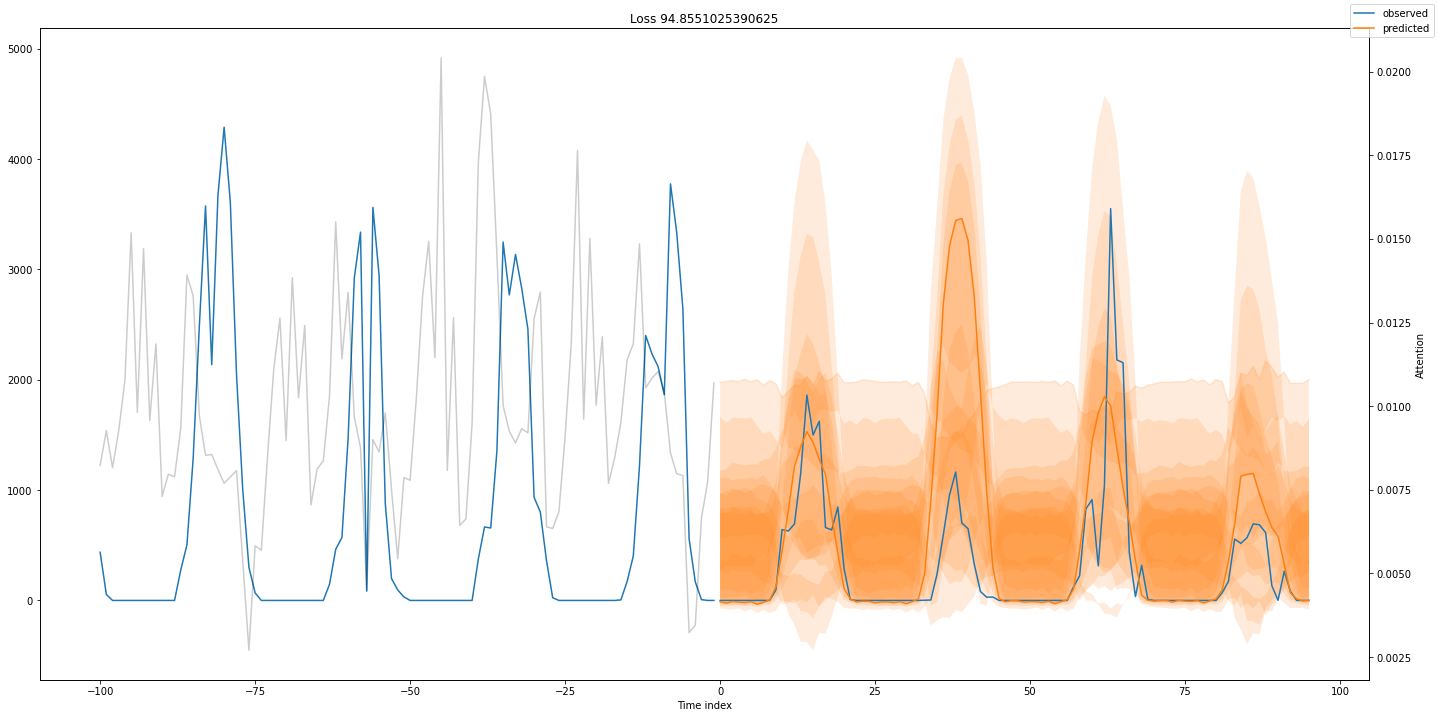

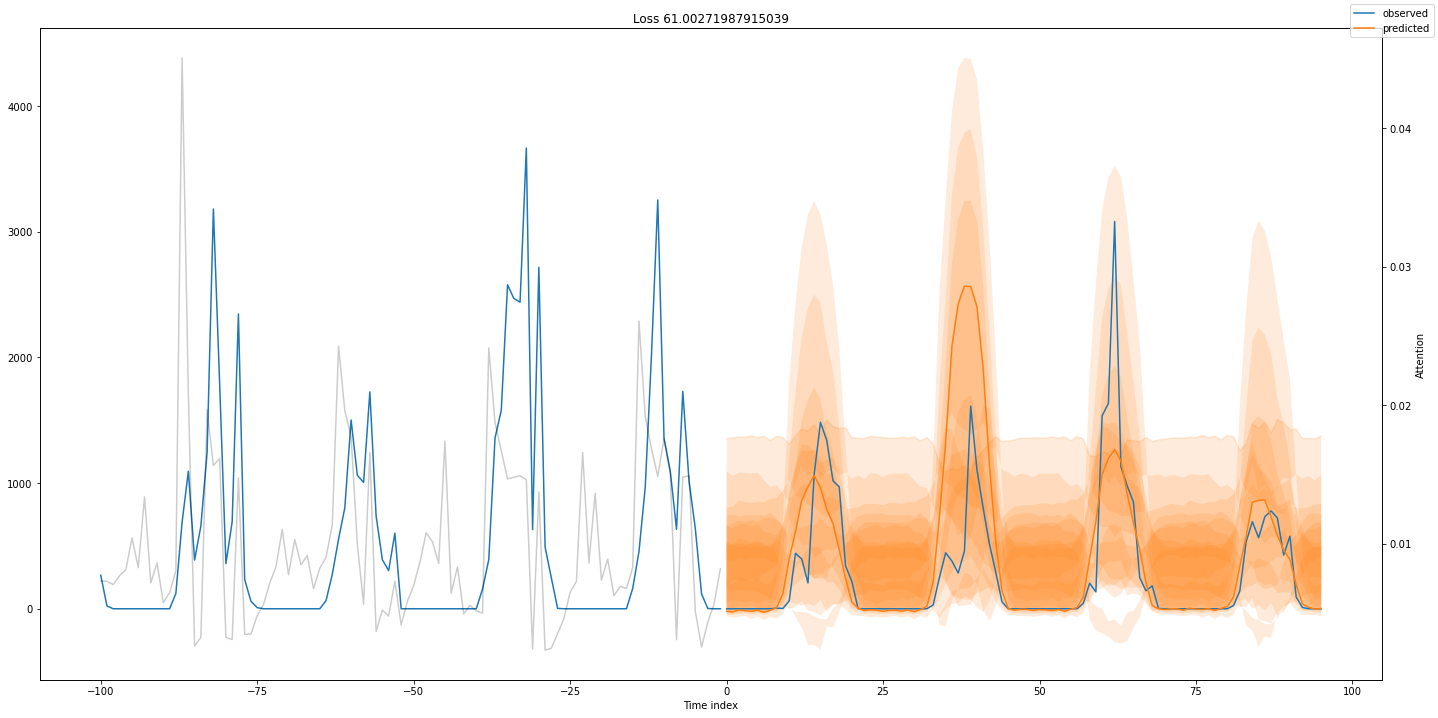

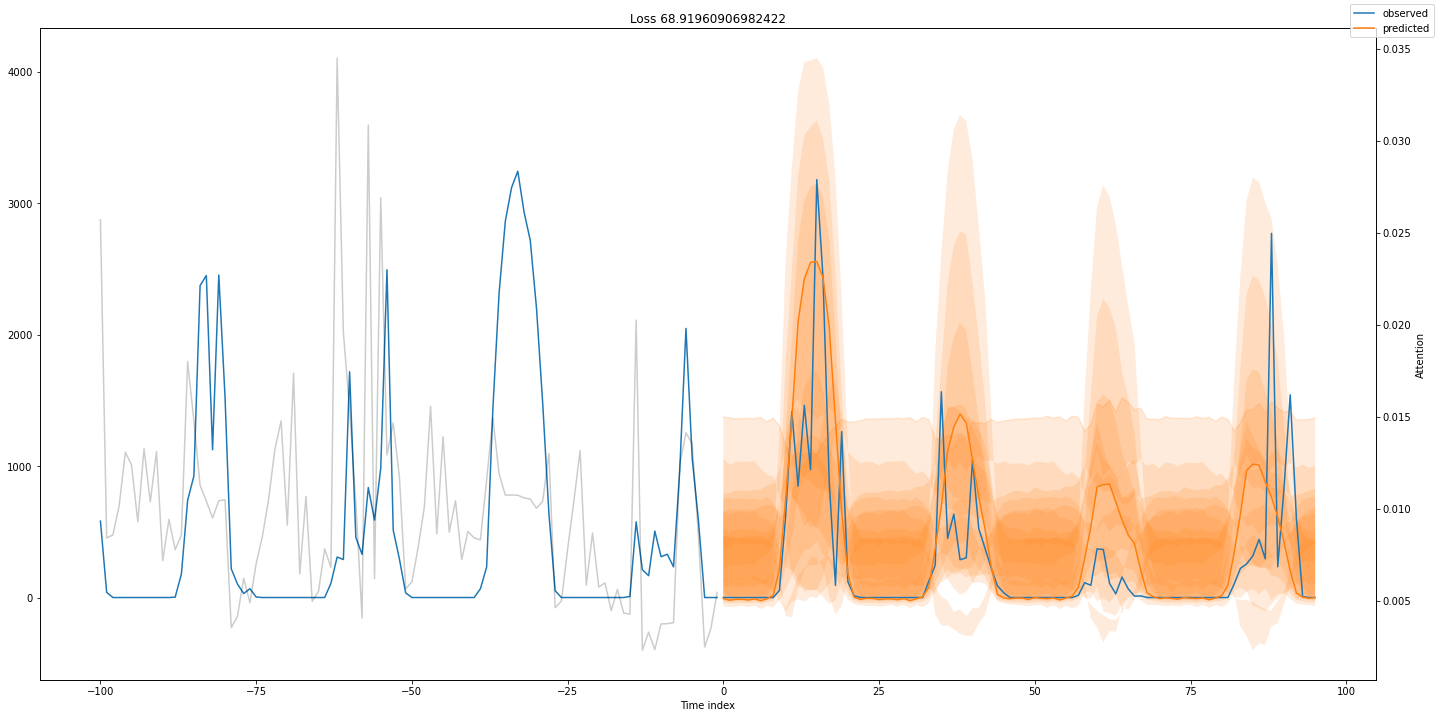

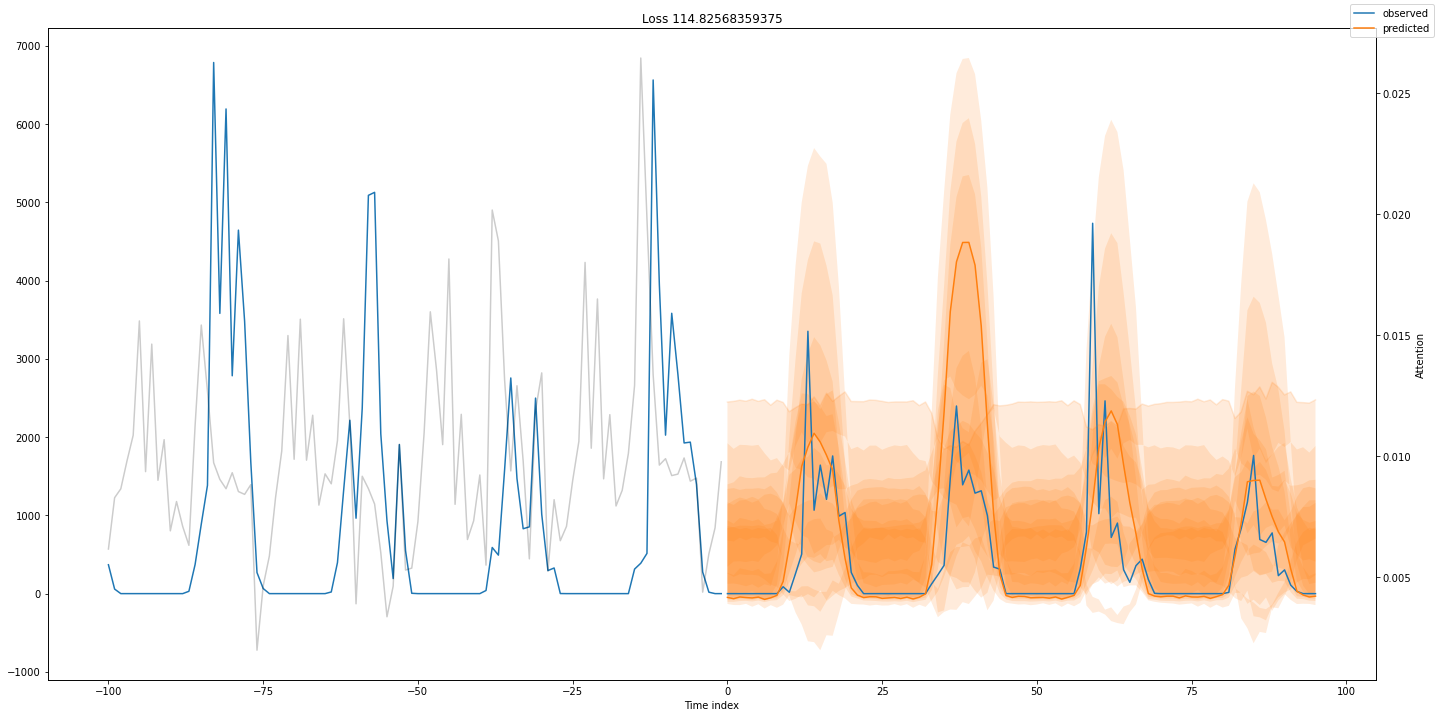

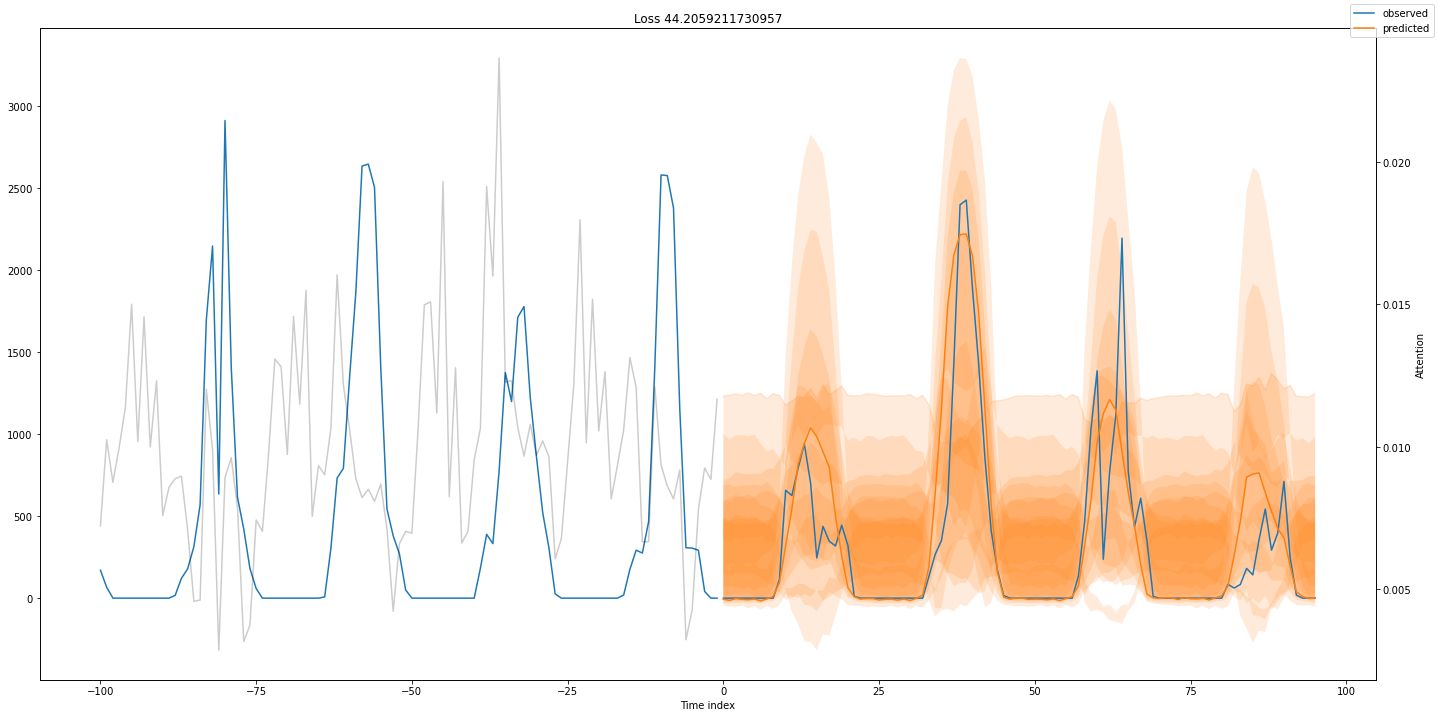

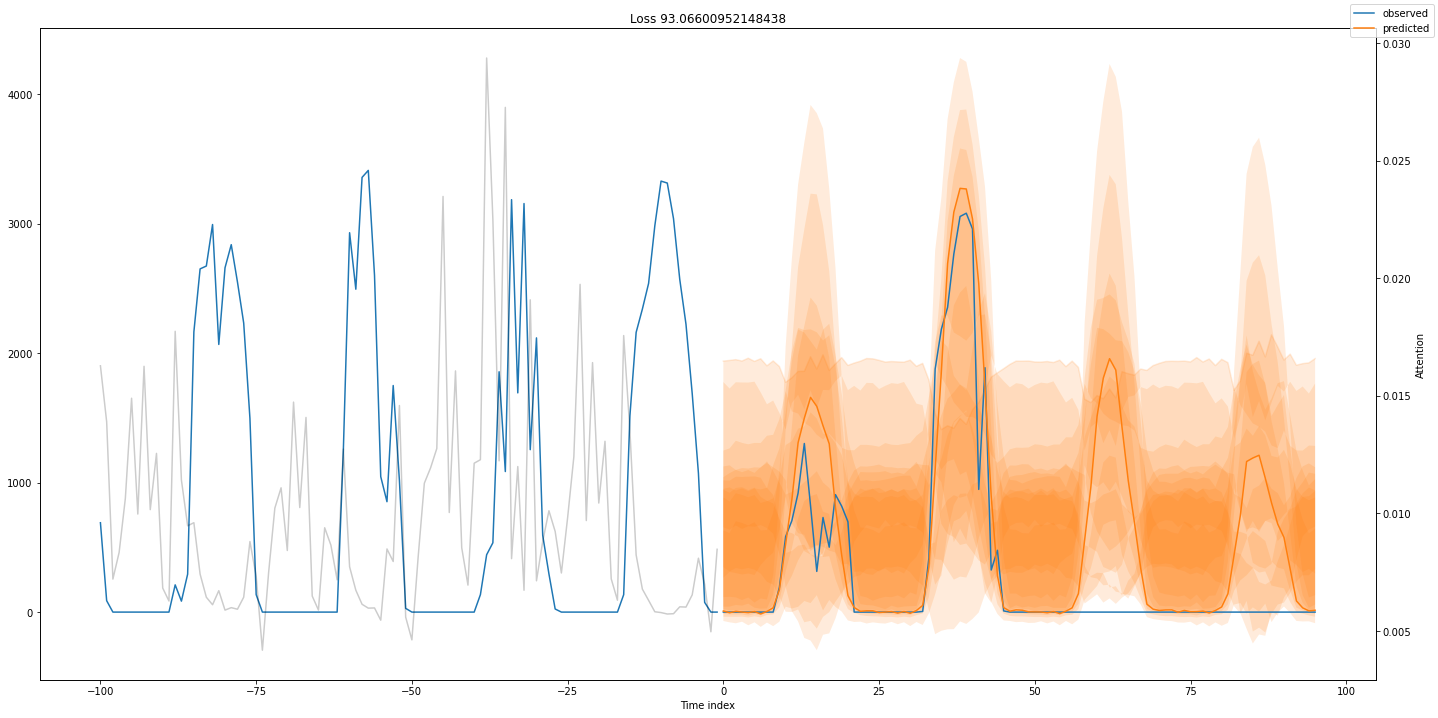

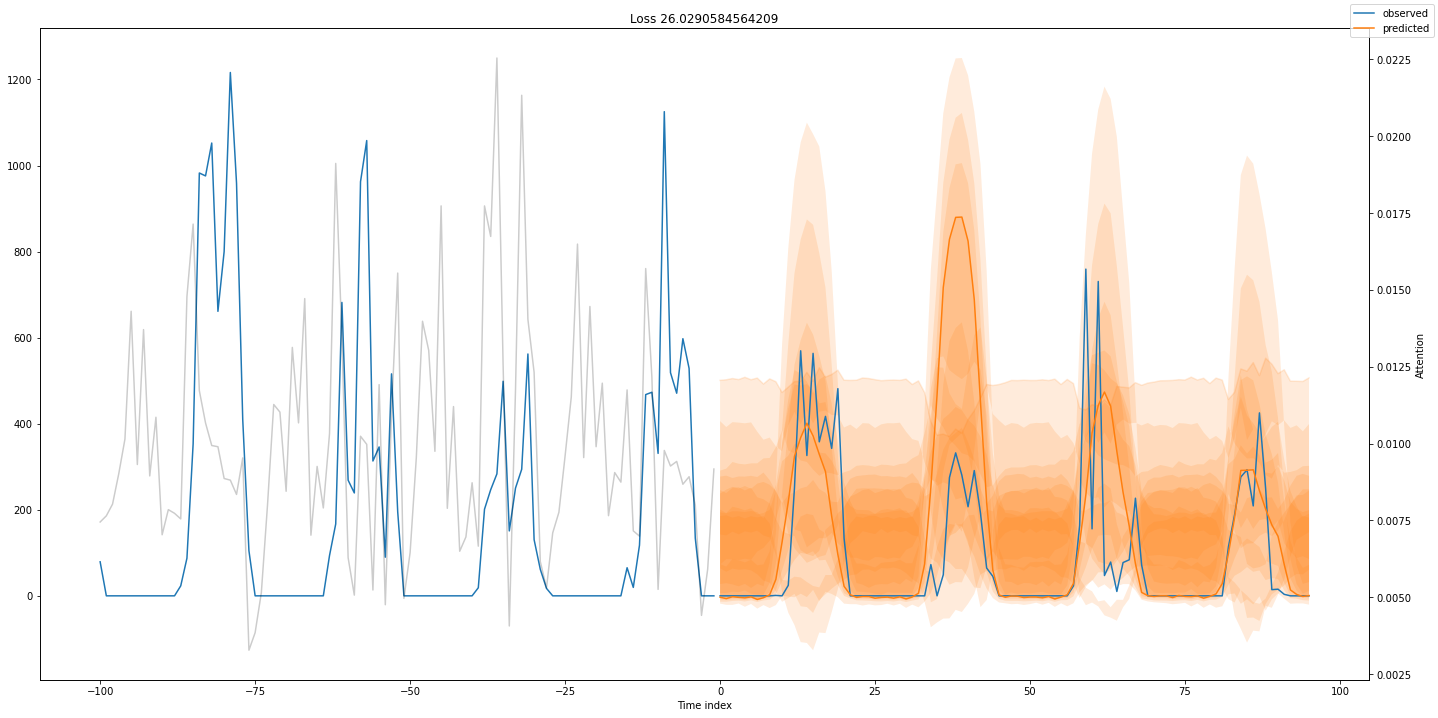

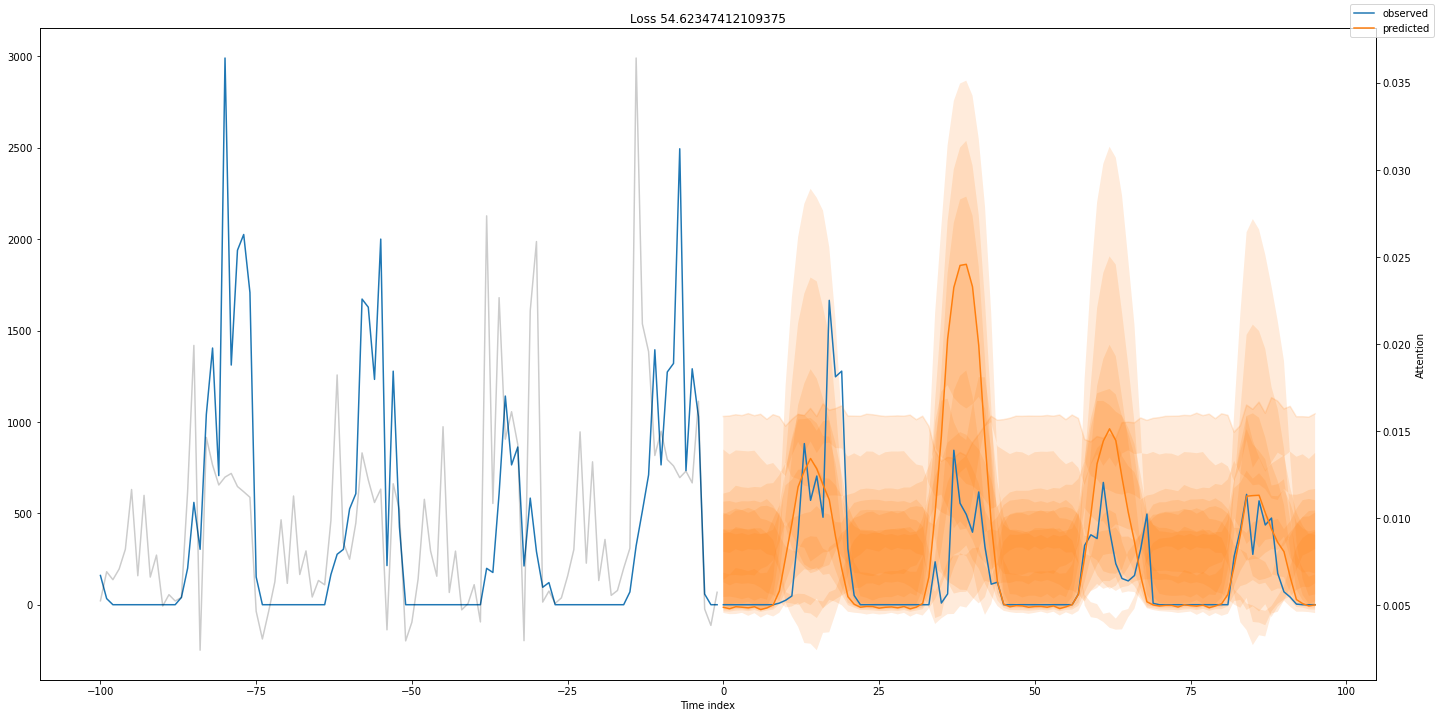

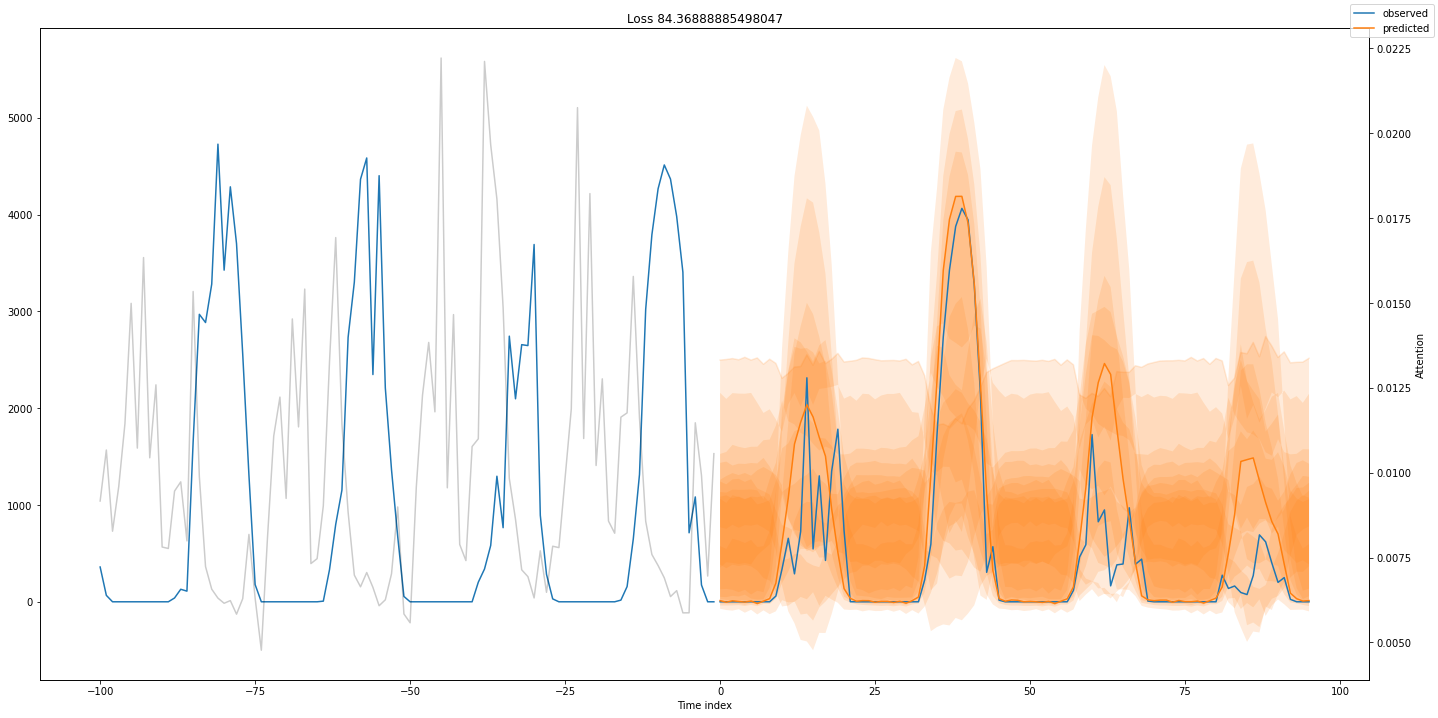

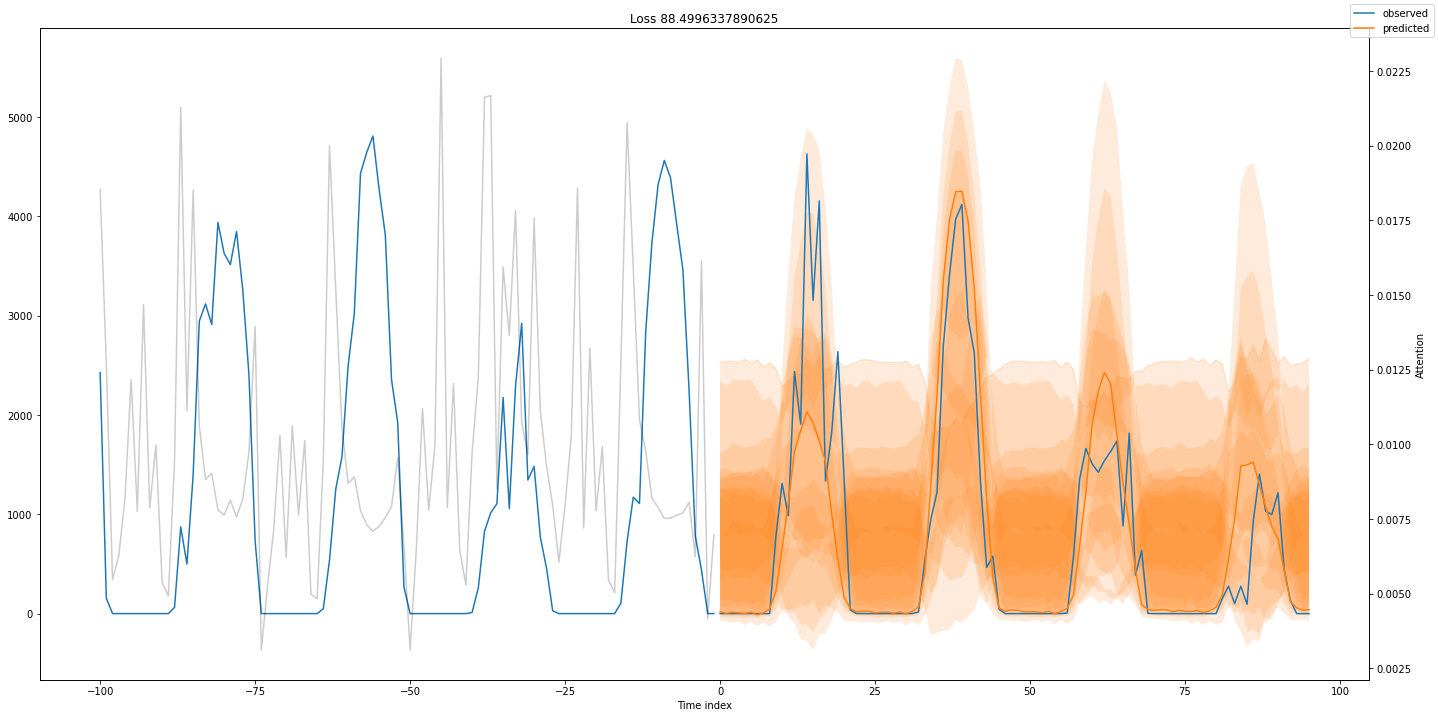

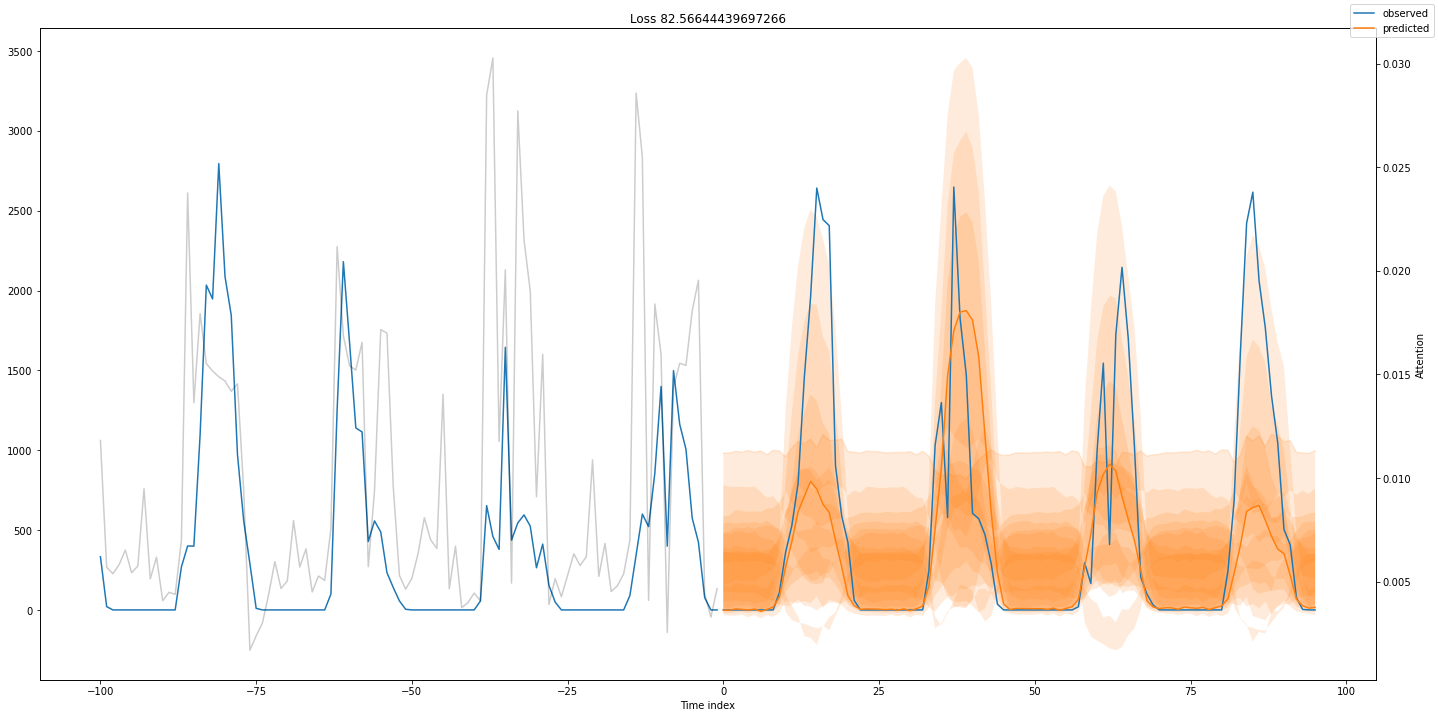

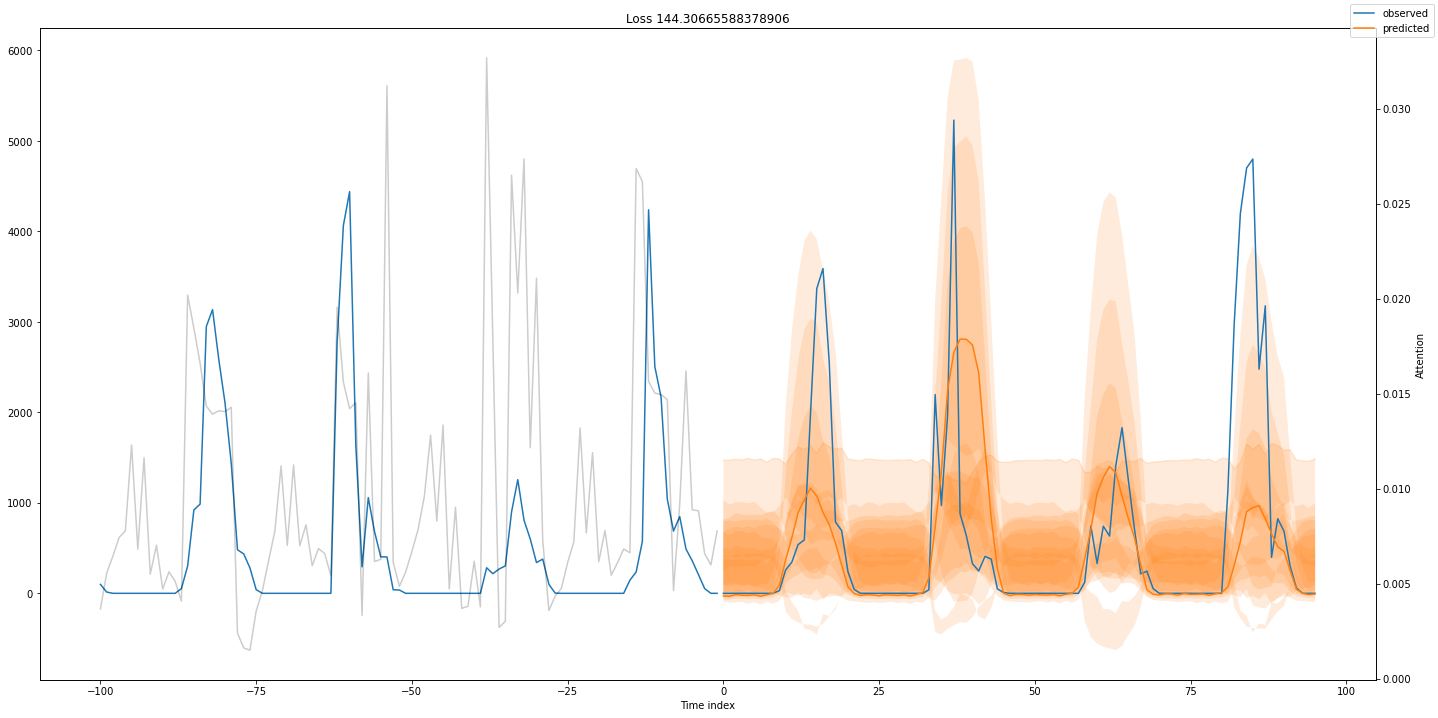

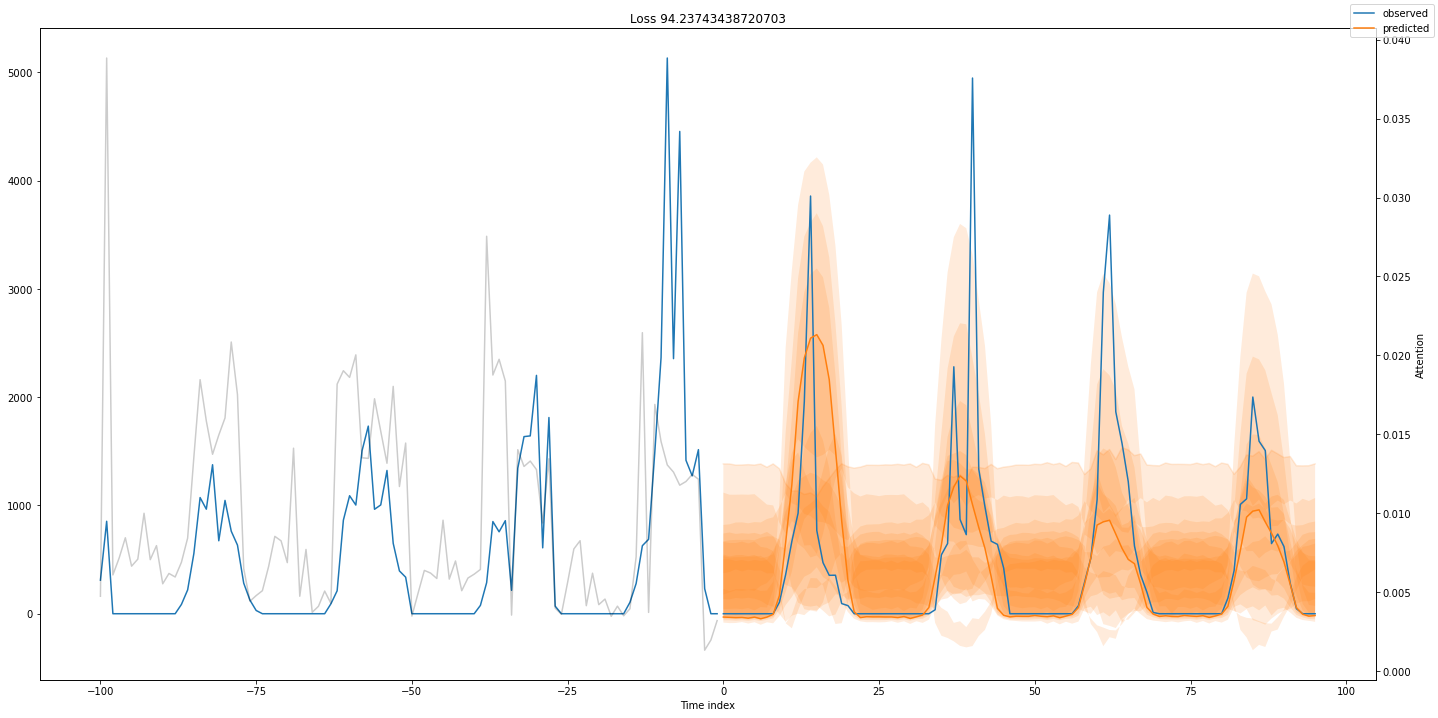

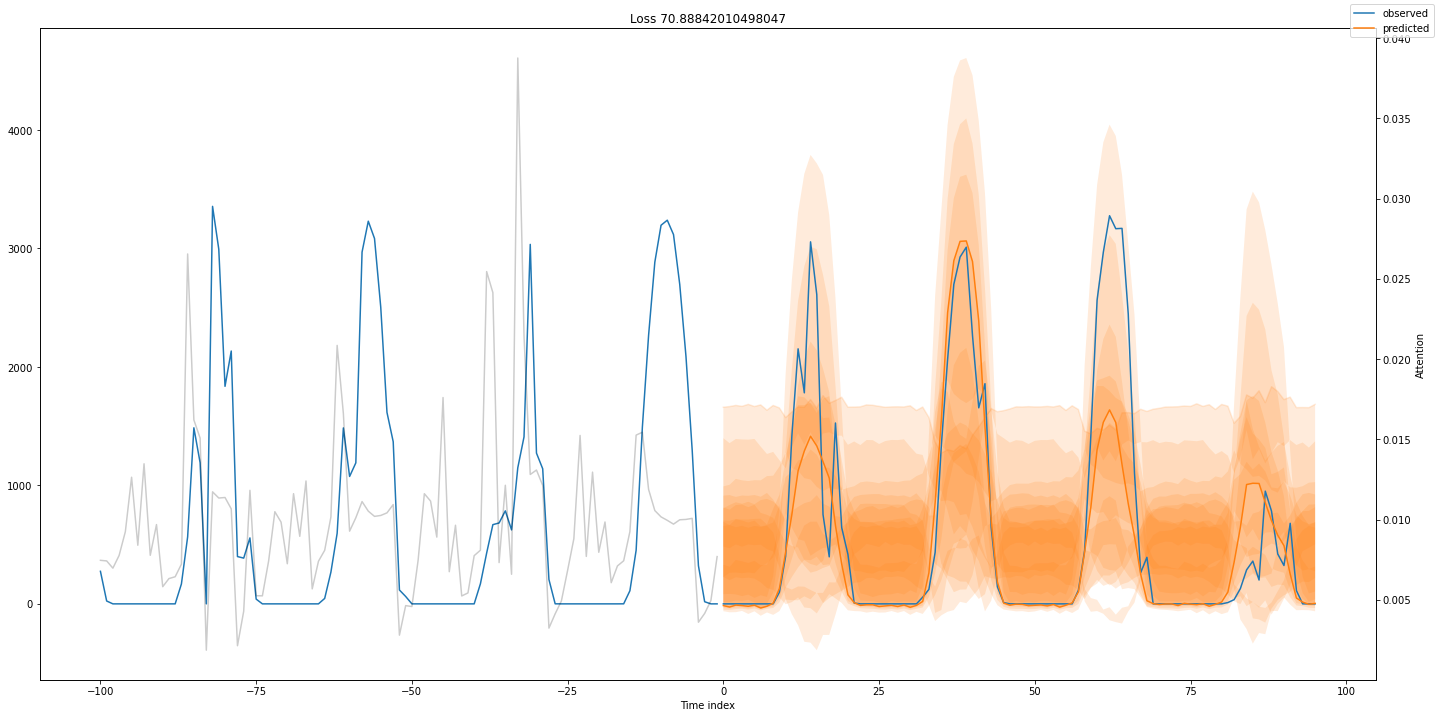

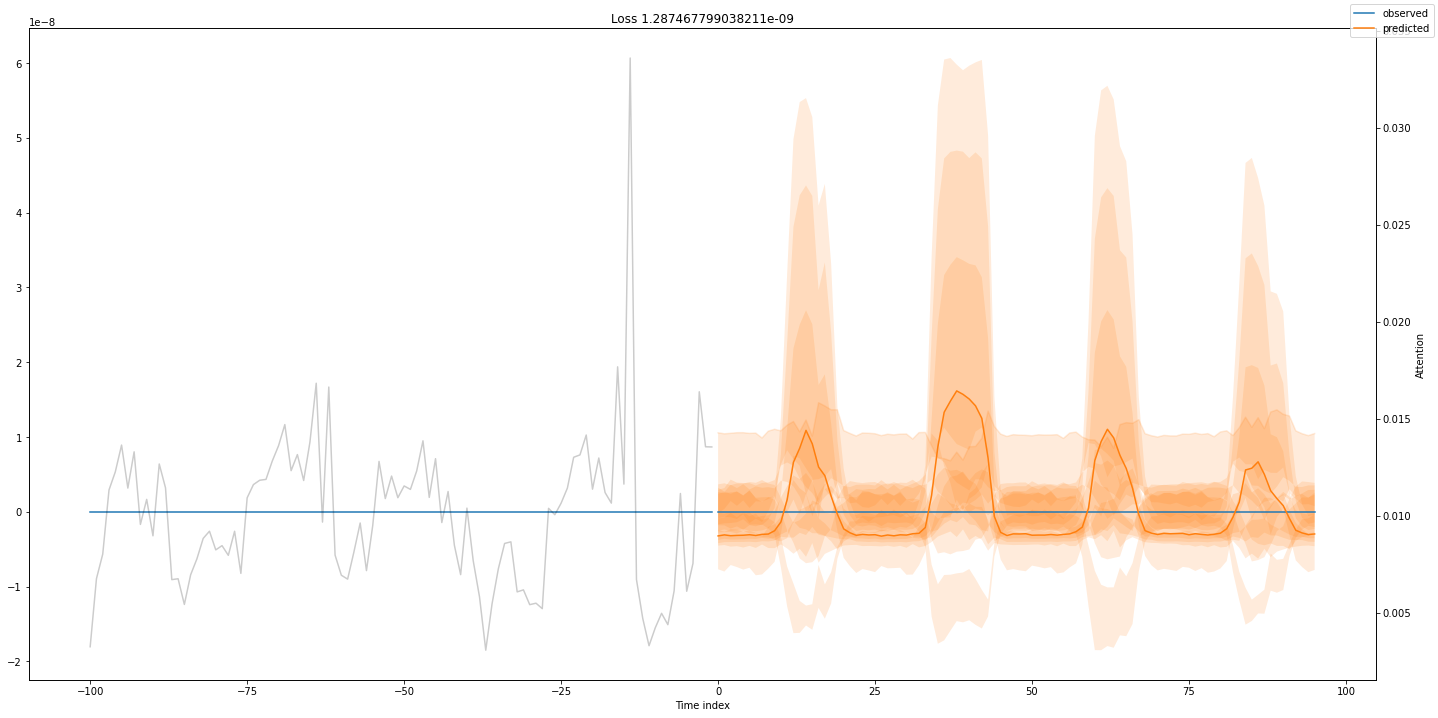

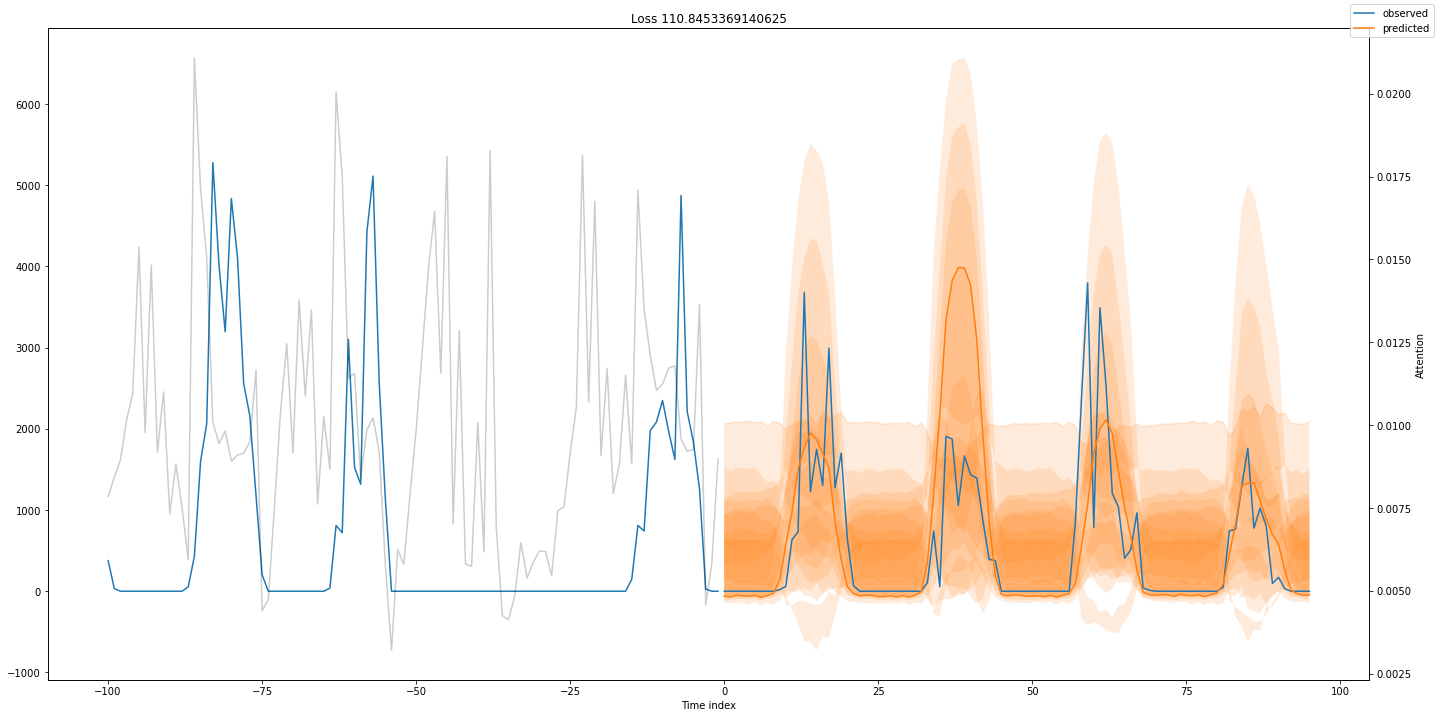

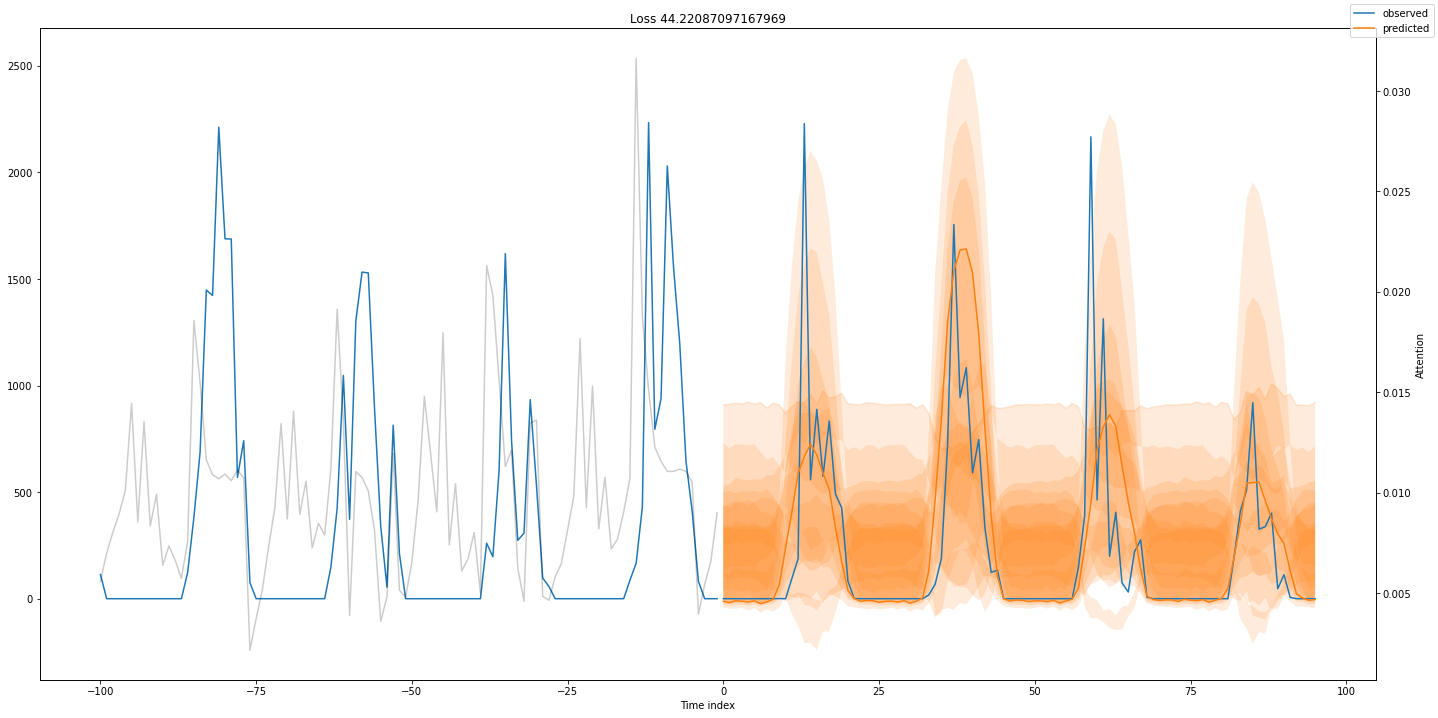

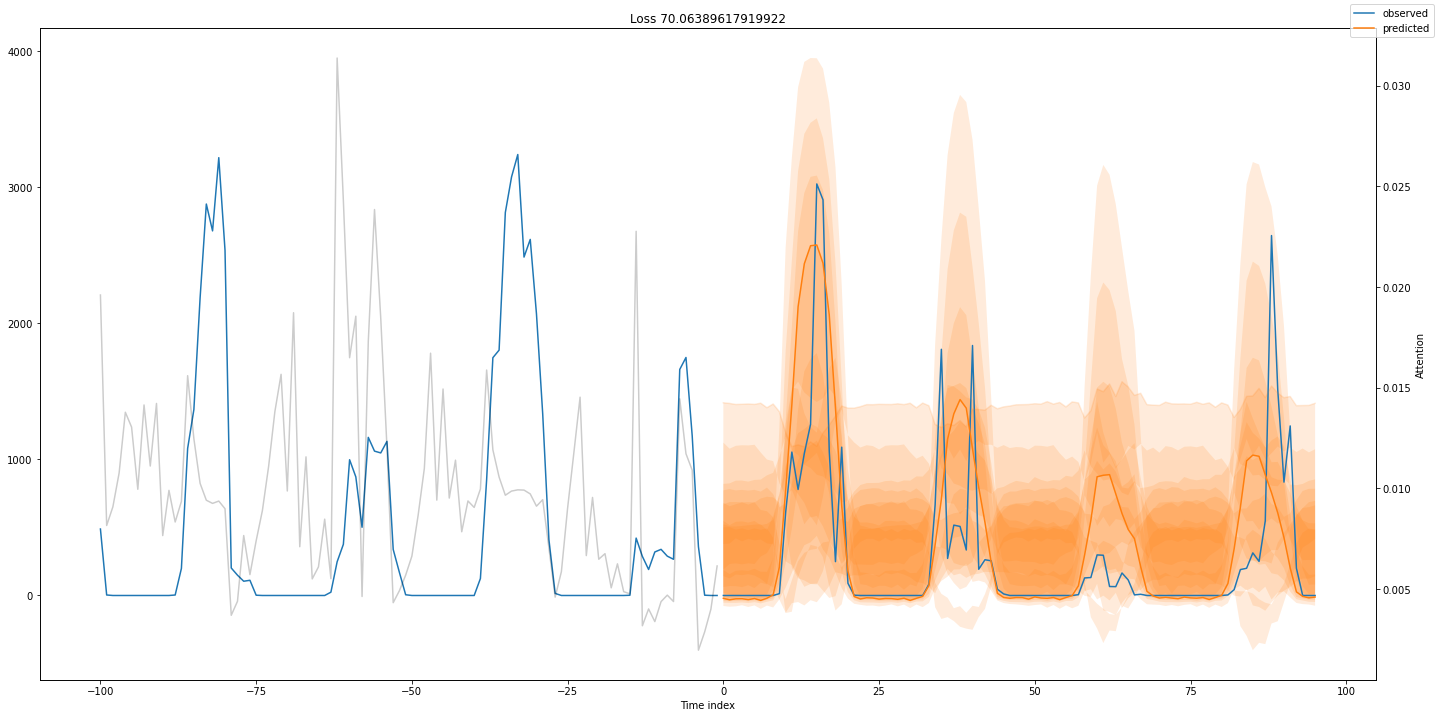

In [20]:
# load the best model according to the validation loss
# (given that we use early stopping, this is not necessarily the last epoch)
import matplotlib as plt
plt.rcParams['figure.figsize'] = [20, 10]
best_model_path = trainer.checkpoint_callback.best_model_path
best_tft = TemporalFusionTransformer.load_from_checkpoint(best_model_path)

# calcualte mean absolute error on validation set
actuals = torch.cat([y[0] for x, y in iter(val_dataloader)])
predictions = best_tft.predict(val_dataloader)
(actuals - predictions).abs().mean()

mae = (actuals - predictions).abs().mean().item()
print(mae)
#print(actuals)
#print(predictions)

# raw predictions are a dictionary from which all kind of information including quantiles can be extracted
raw_predictions, x = best_tft.predict(val_dataloader, mode="raw", return_x=True)
for idx in range(22):  # plot 10 examples
    best_tft.plot_prediction(x, raw_predictions, idx=idx, add_loss_to_title=True);

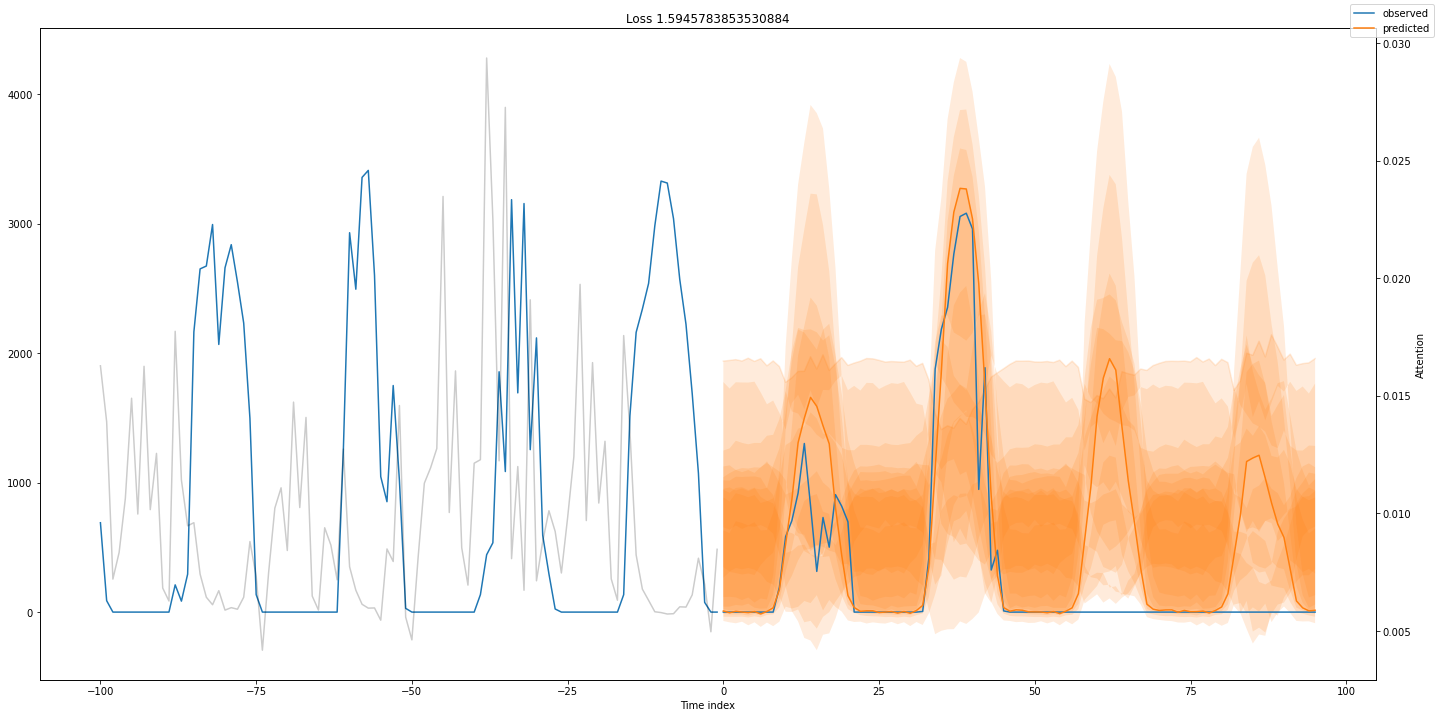

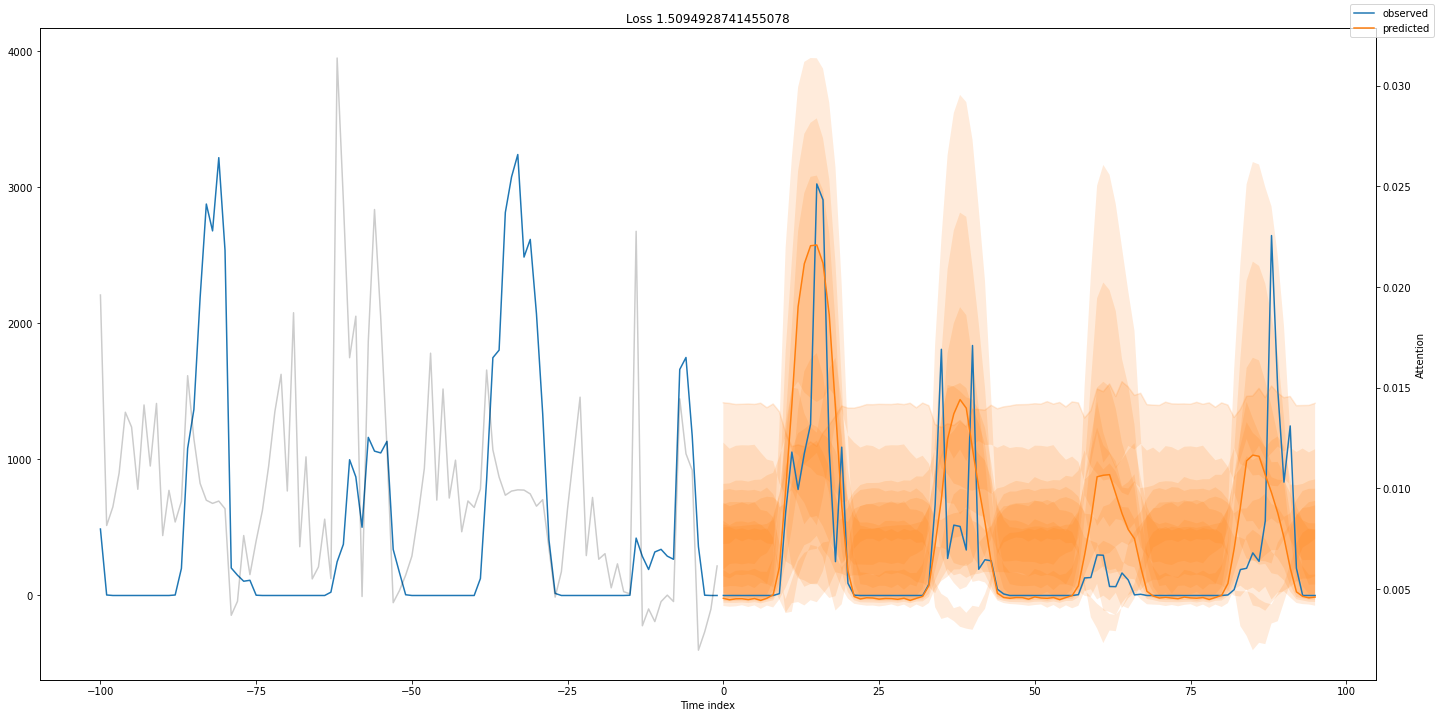

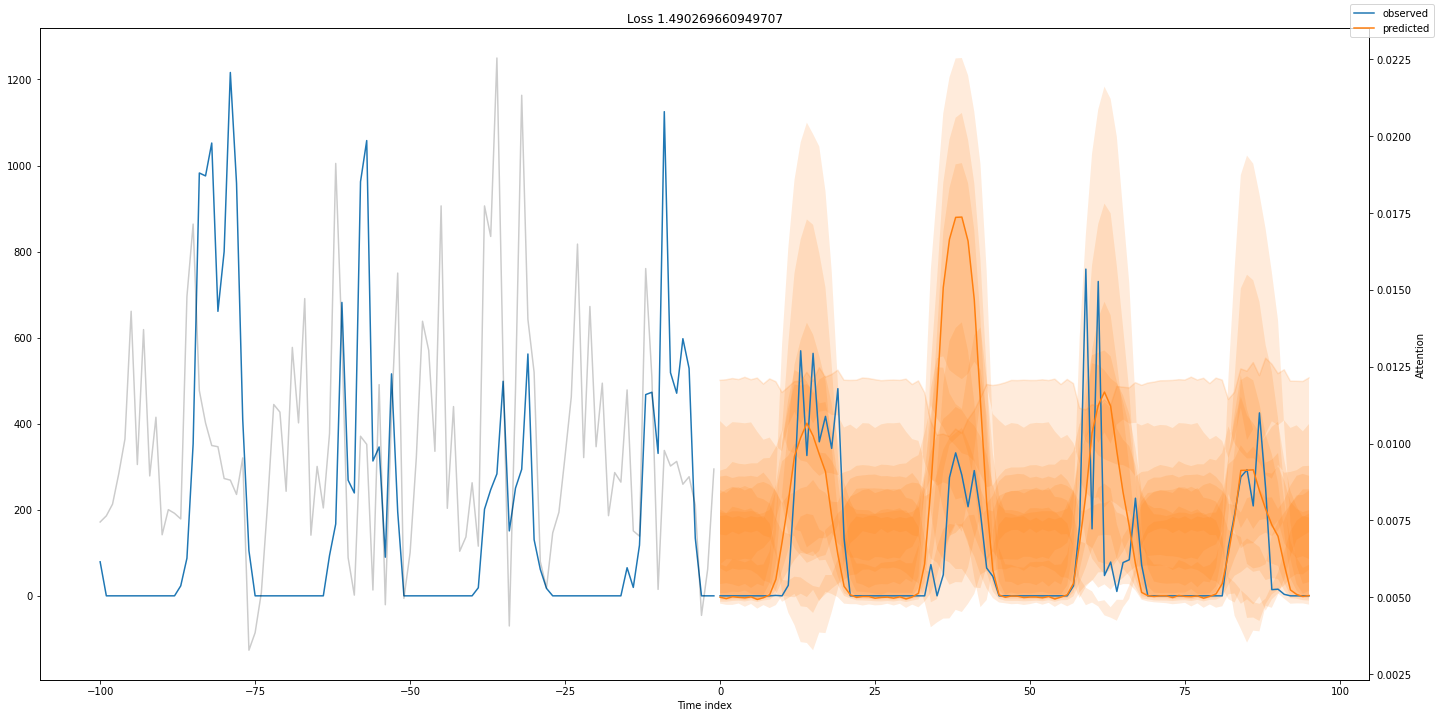

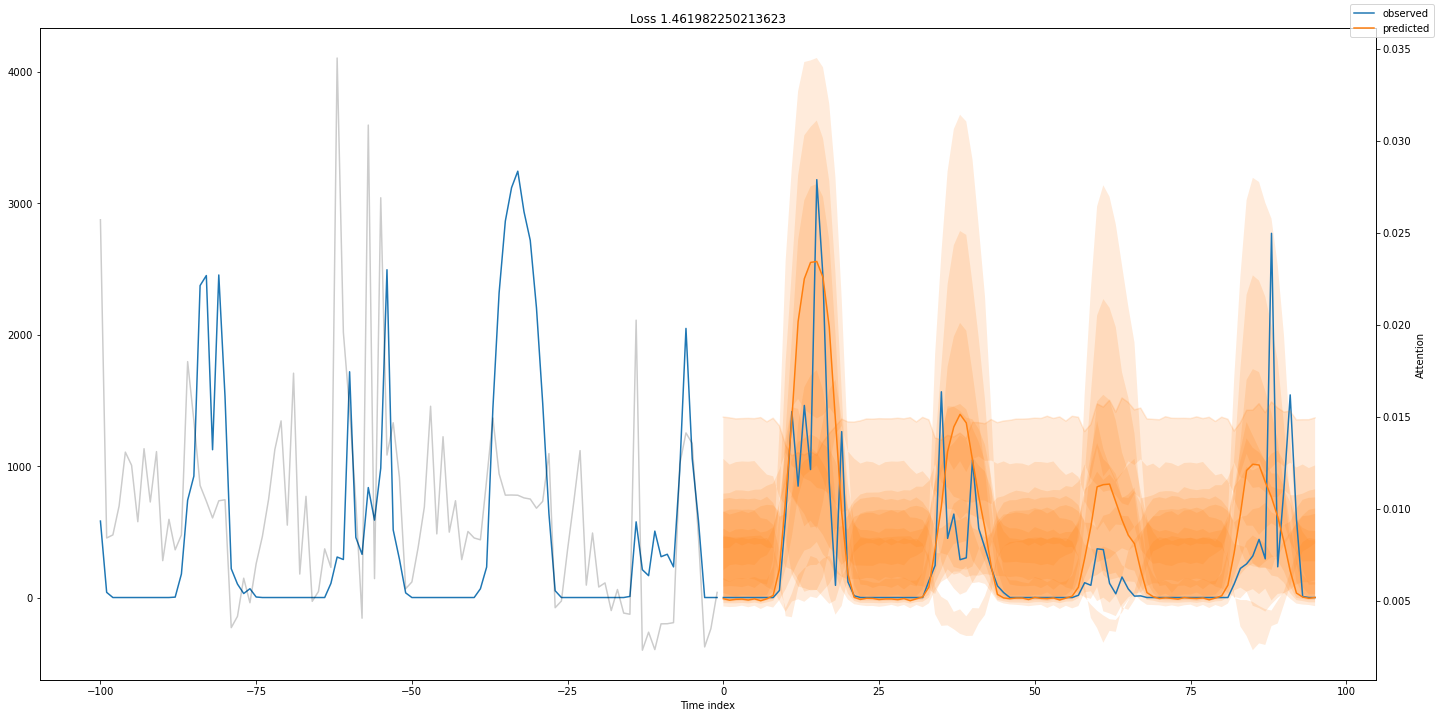

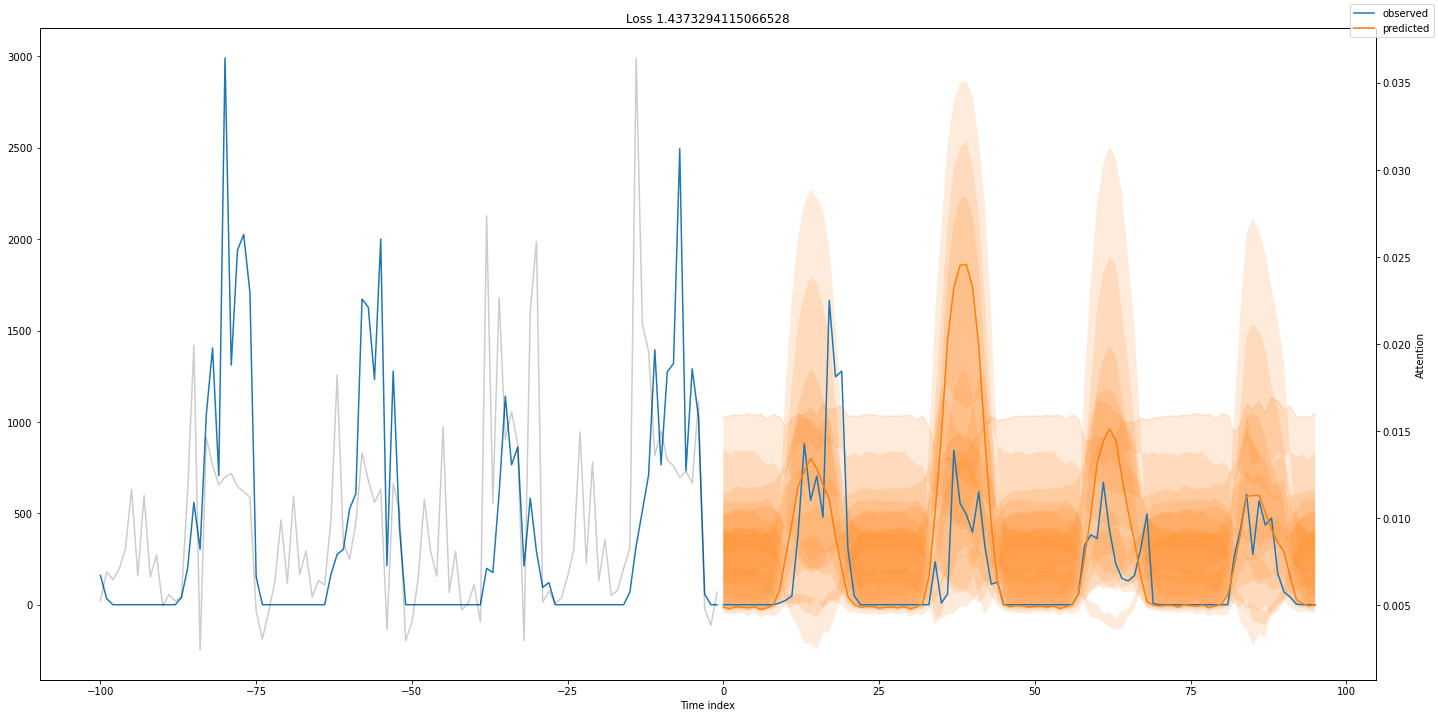

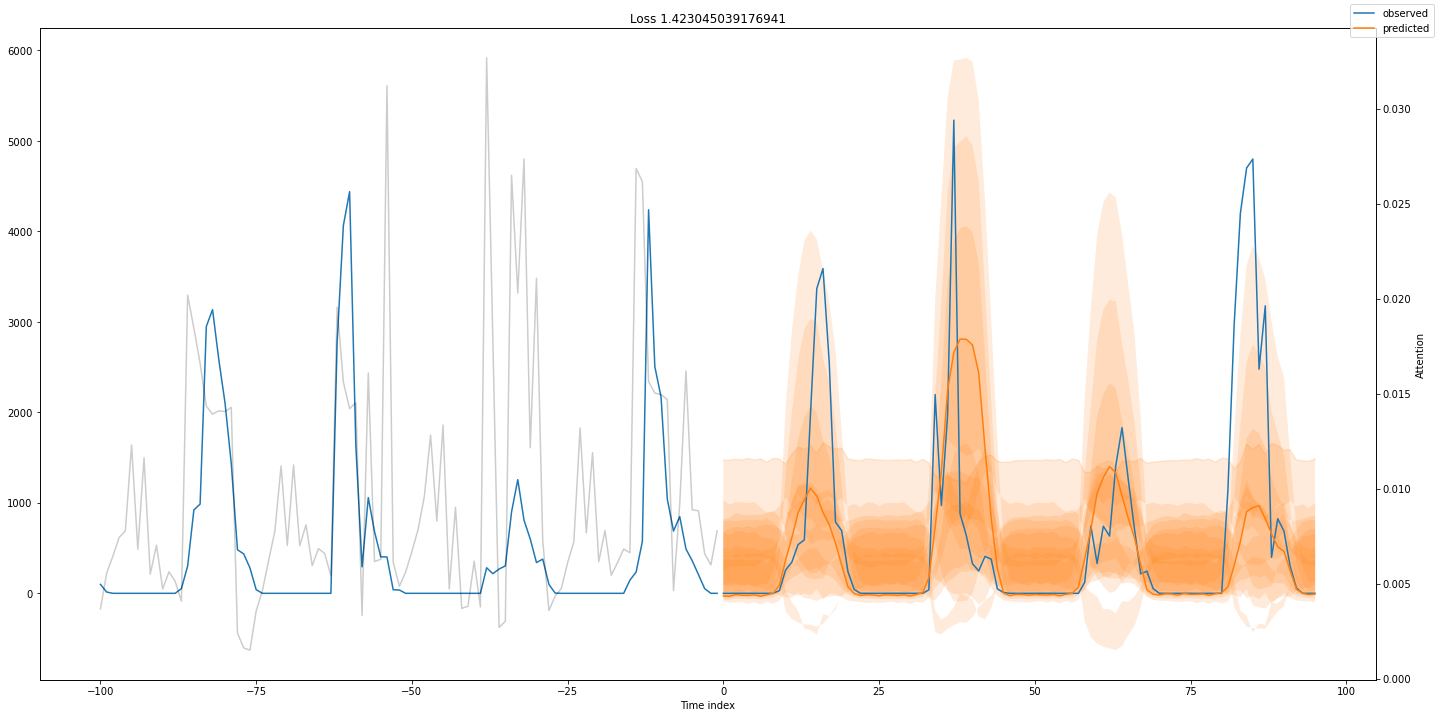

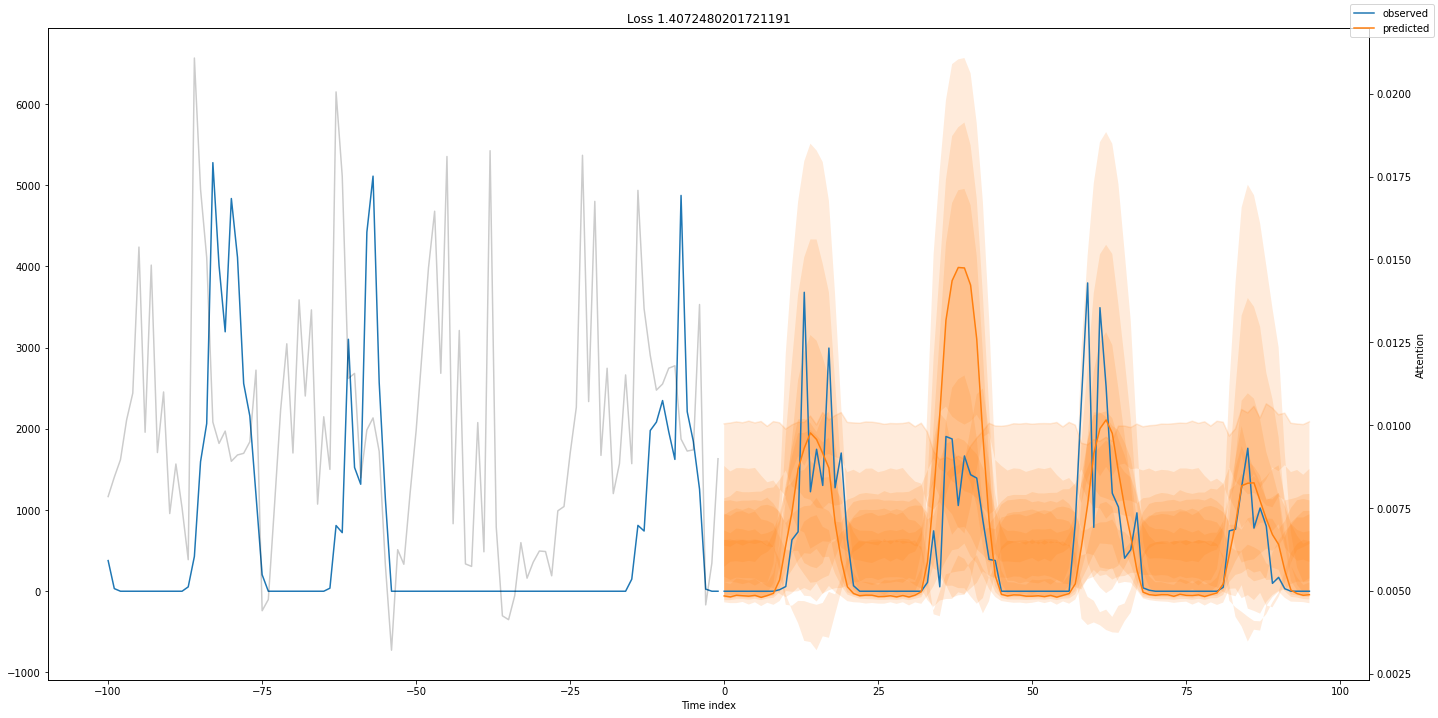

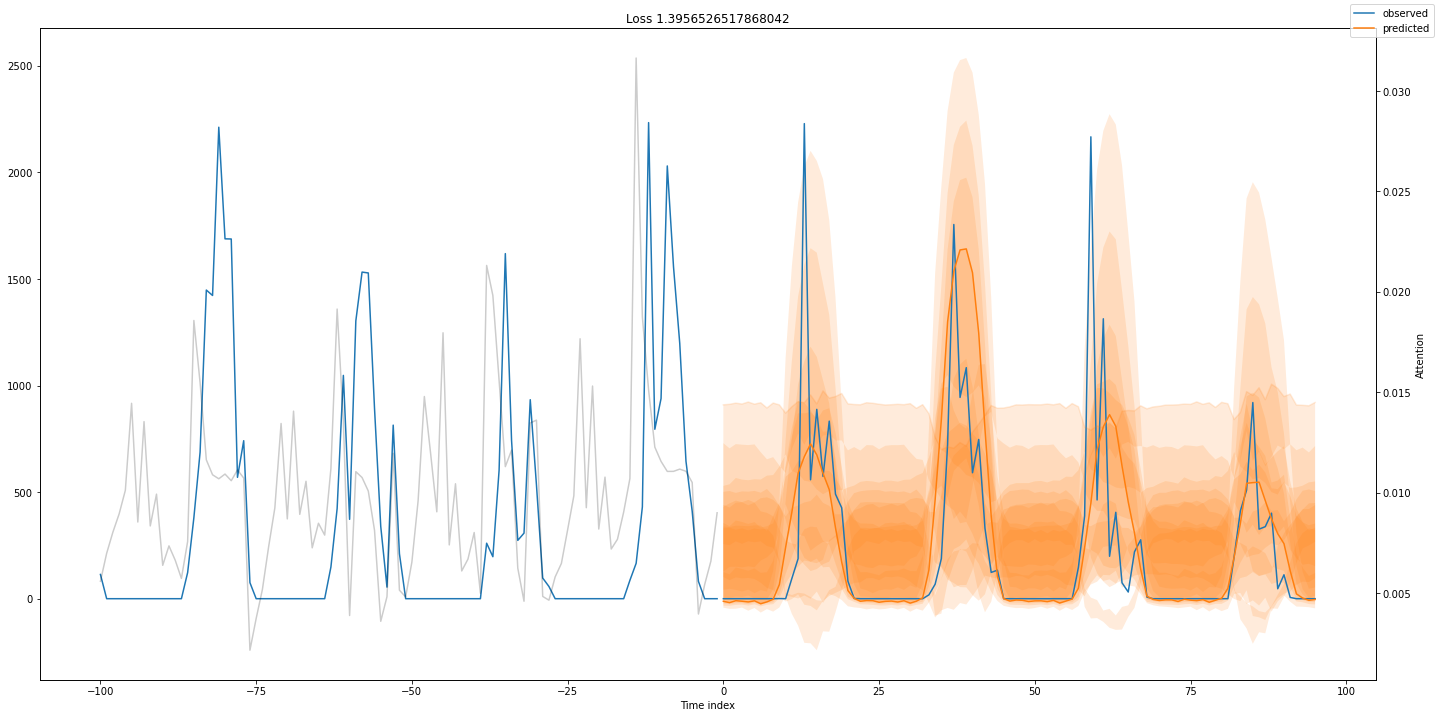

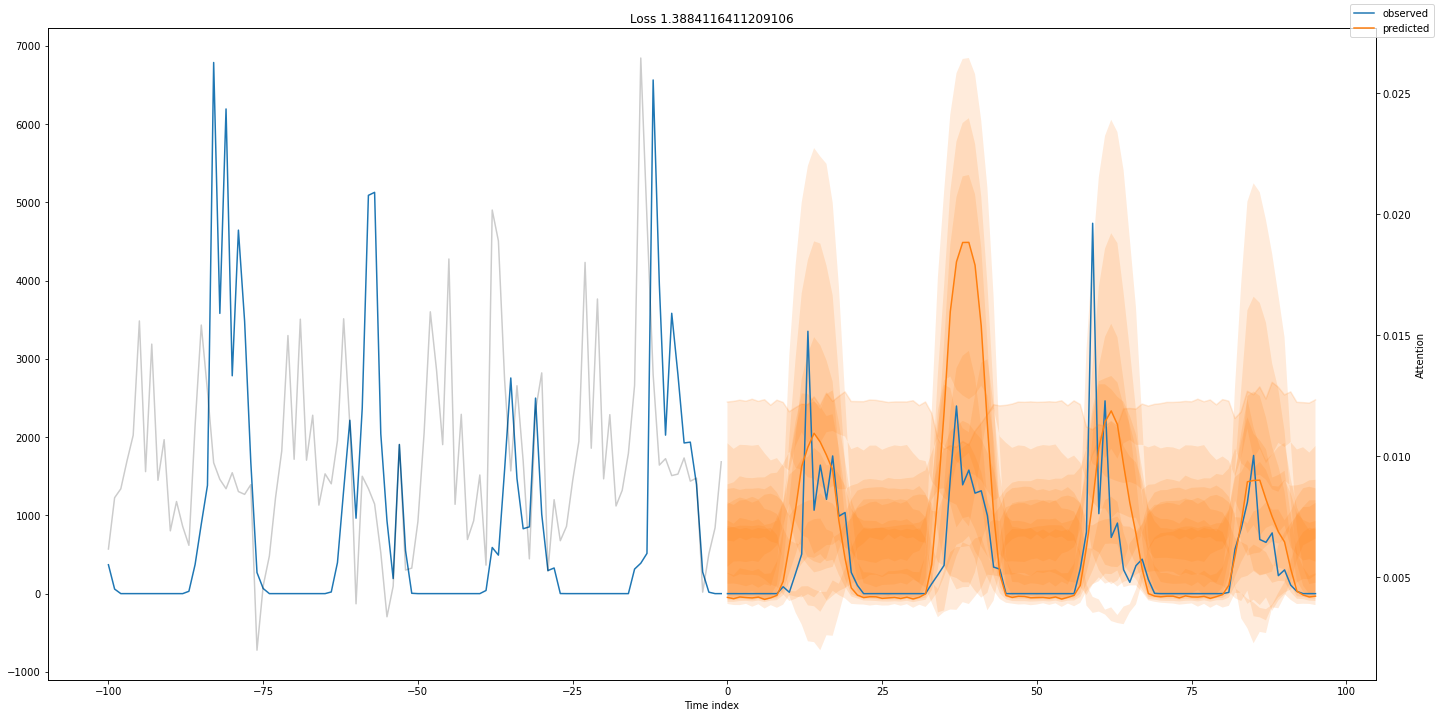

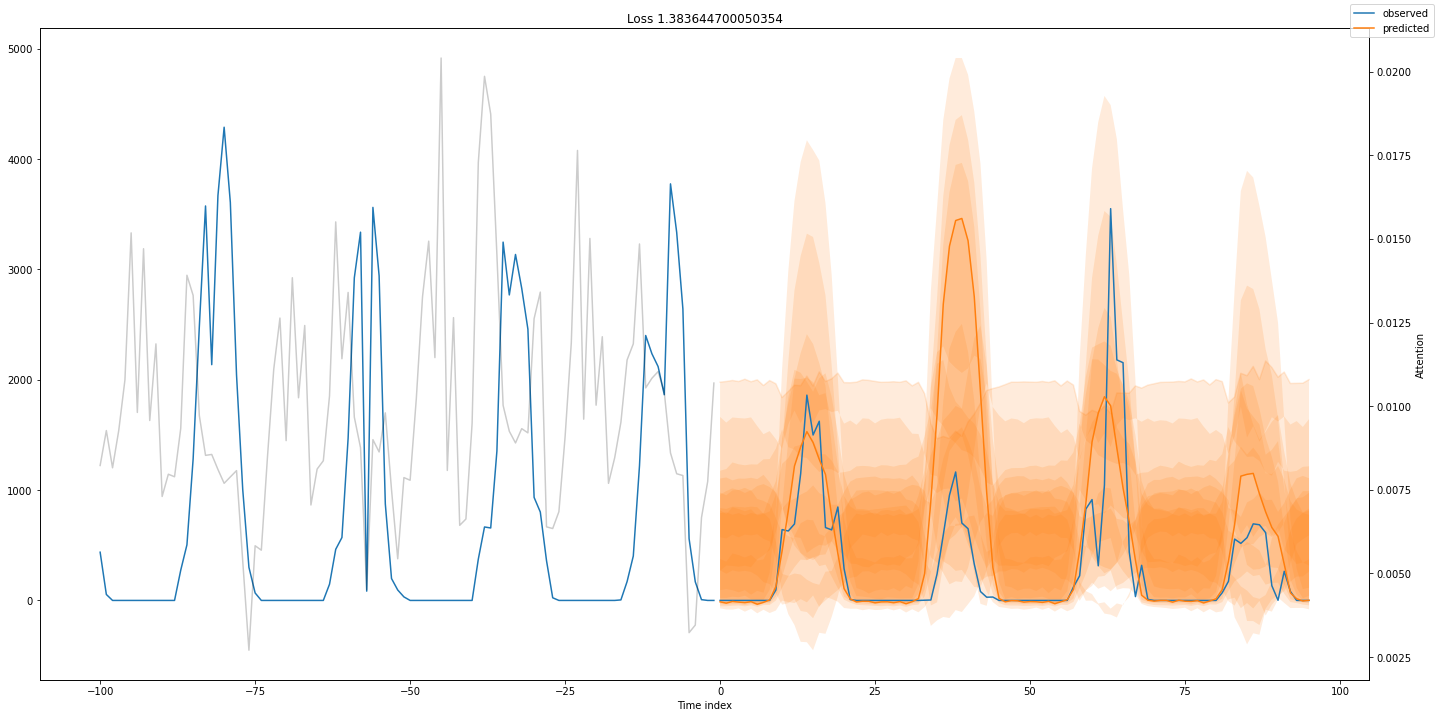

In [21]:
# TEST ON DIFFERENT METRIC
# calcualte metric by which to display
predictions = best_tft.predict(val_dataloader)
mean_losses = SMAPE(reduction="none")(predictions, actuals).mean(1)
indices = mean_losses.argsort(descending=True)  # sort losses

for idx in range(10):  # plot 10 examples
    best_tft.plot_prediction(x, raw_predictions, idx=indices[idx], add_loss_to_title=SMAPE());

/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/pytorch_forecasting/models/base_model.py:1271: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).



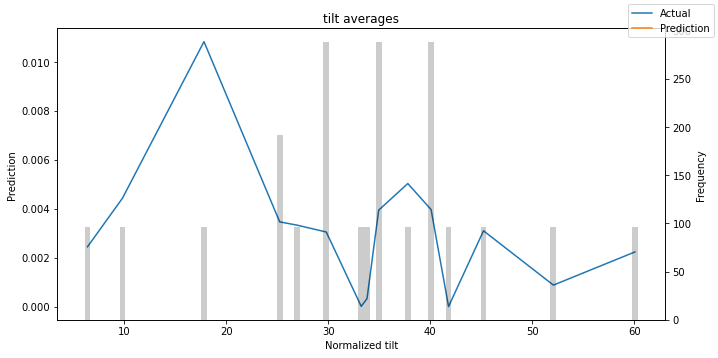

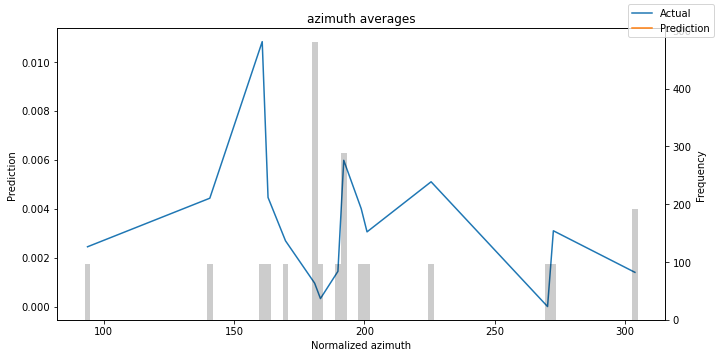

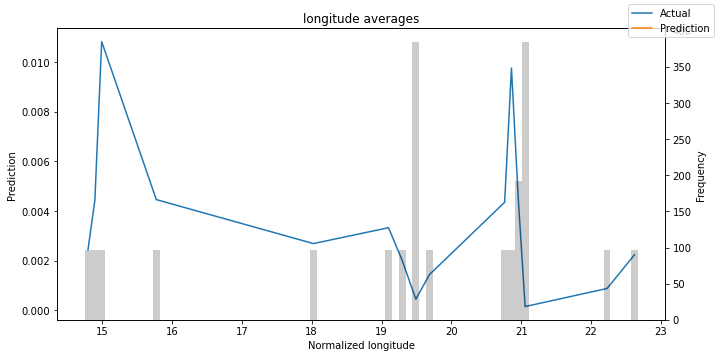

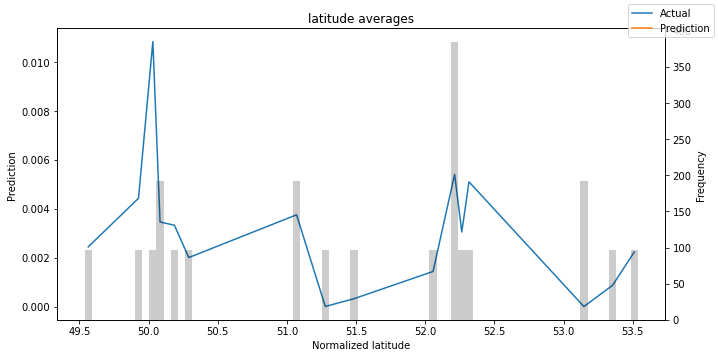

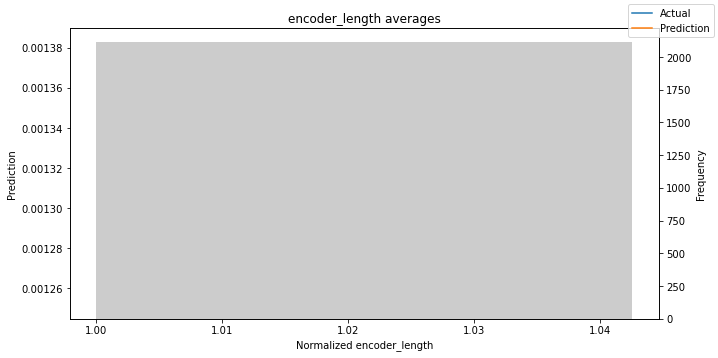

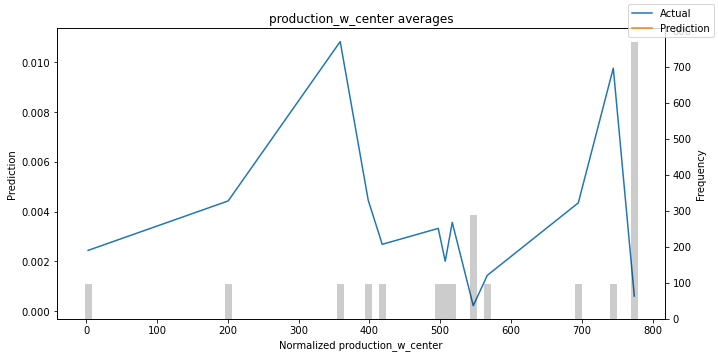

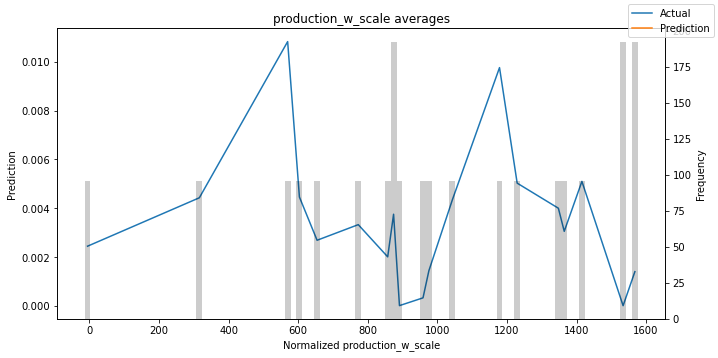

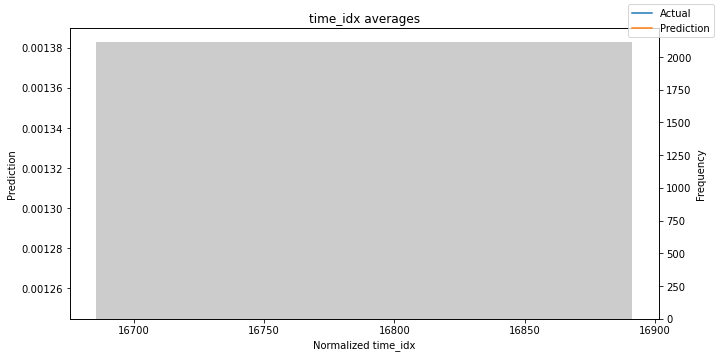

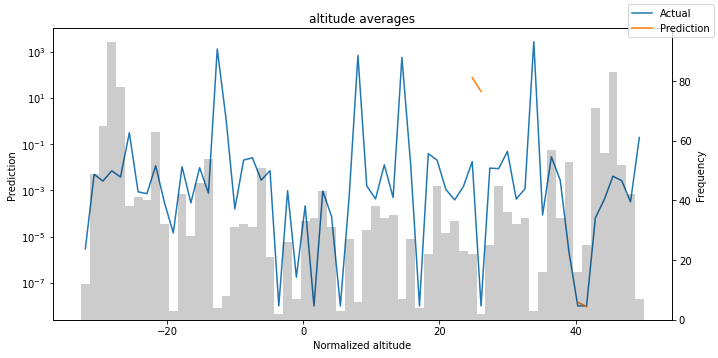

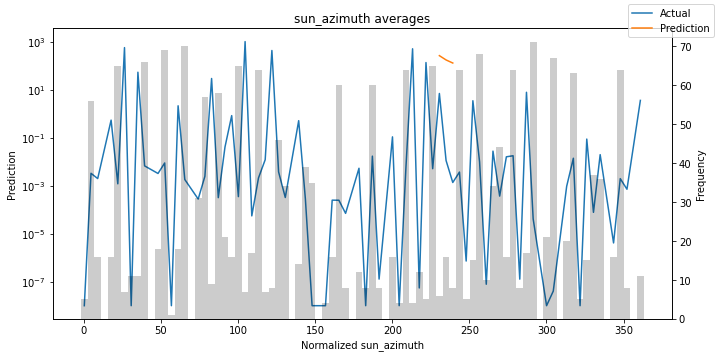

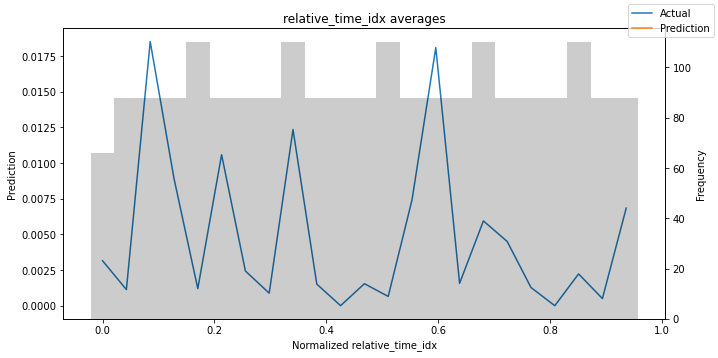

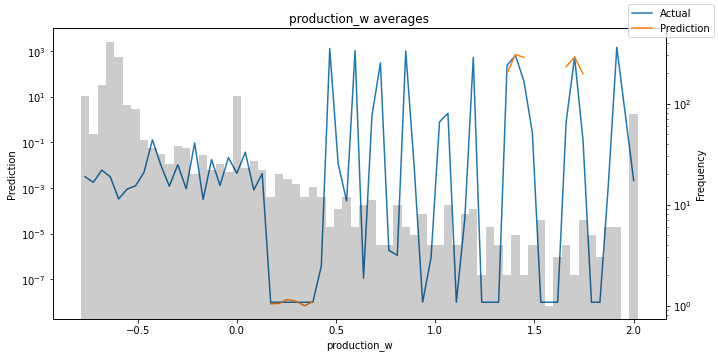

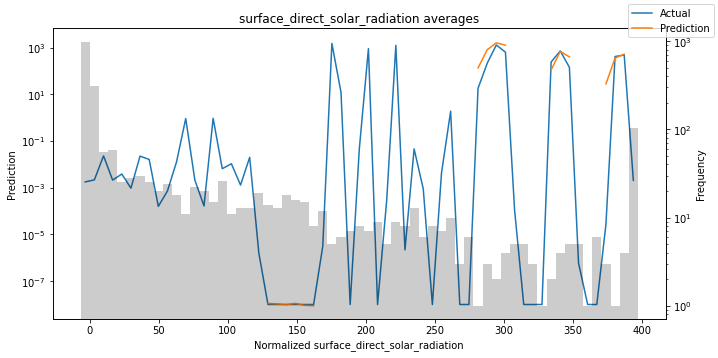

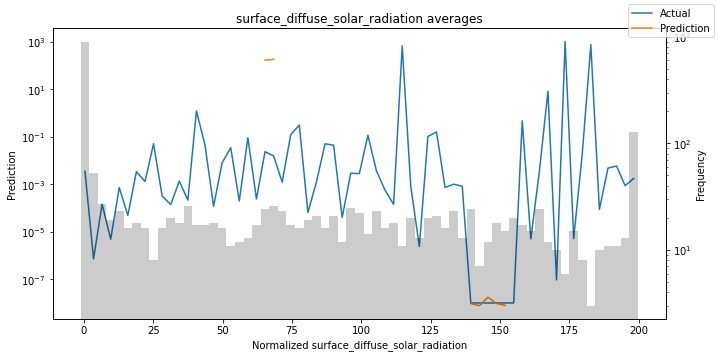

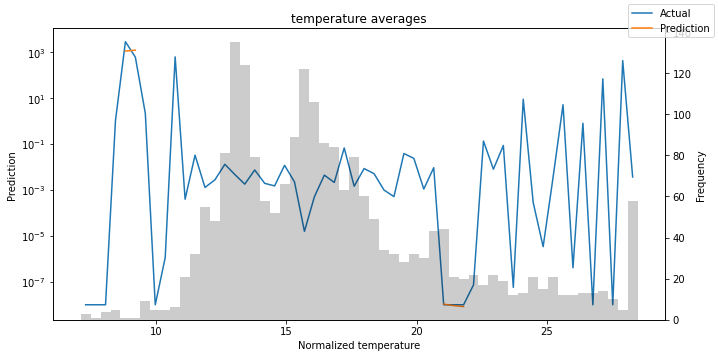

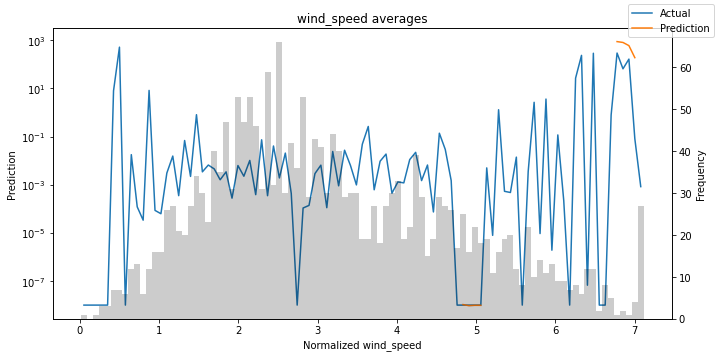

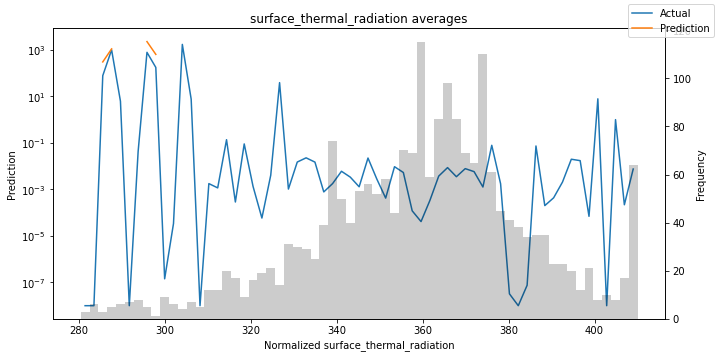

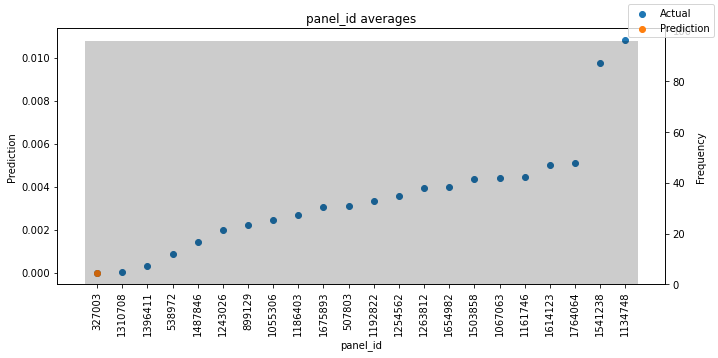

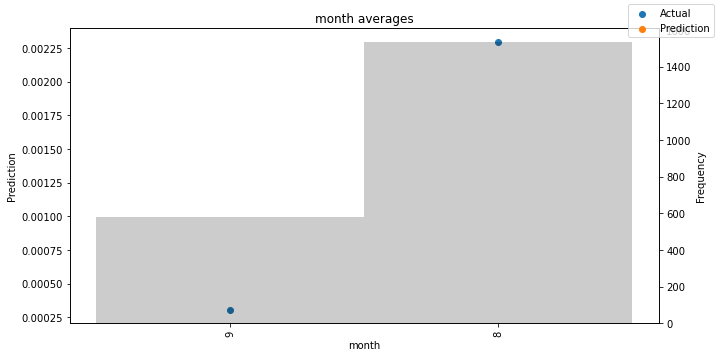

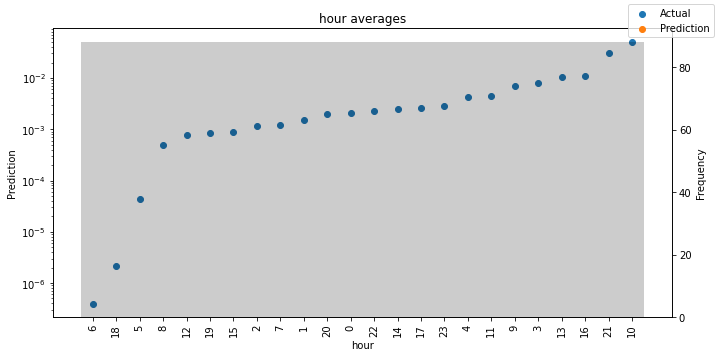

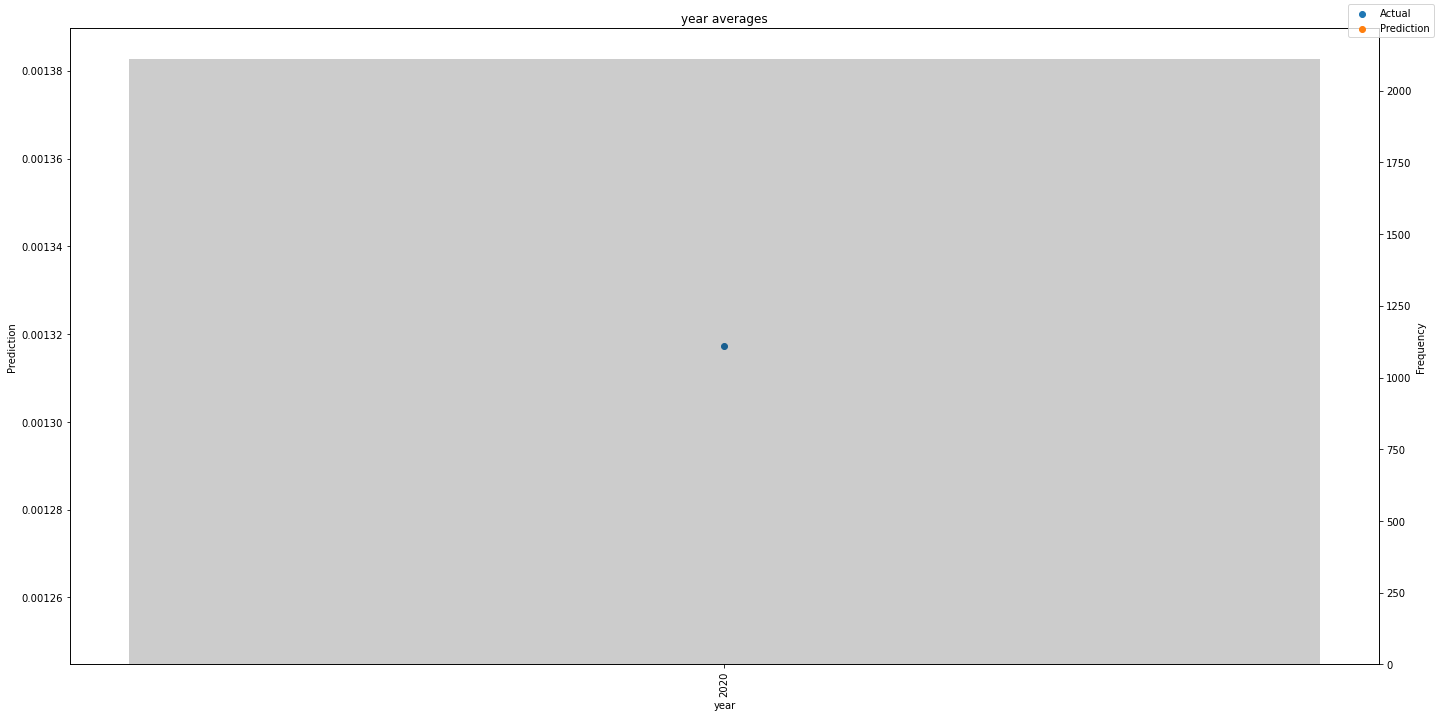

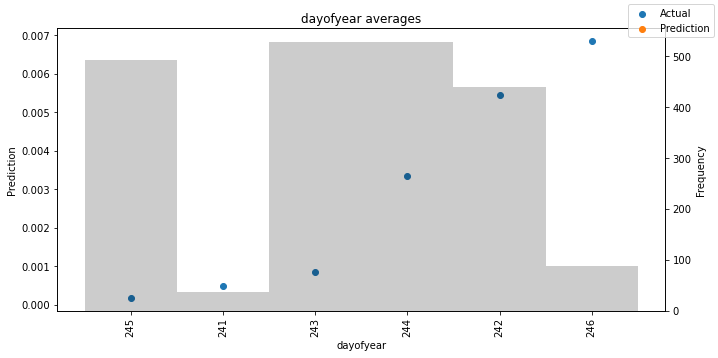

In [22]:
# PREDICTIONS BASED ON VARIABLE
predictions, x = best_tft.predict(val_dataloader, return_x=True)
predictions_vs_actuals = best_tft.calculate_prediction_actual_by_variable(x, predictions)
best_tft.plot_prediction_actual_by_variable(predictions_vs_actuals);

## Summary

{'attention': <Figure size 1440x720 with 1 Axes>,
 'static_variables': <Figure size 504x288 with 1 Axes>,
 'encoder_variables': <Figure size 504x396 with 1 Axes>,
 'decoder_variables': <Figure size 504x288 with 1 Axes>}

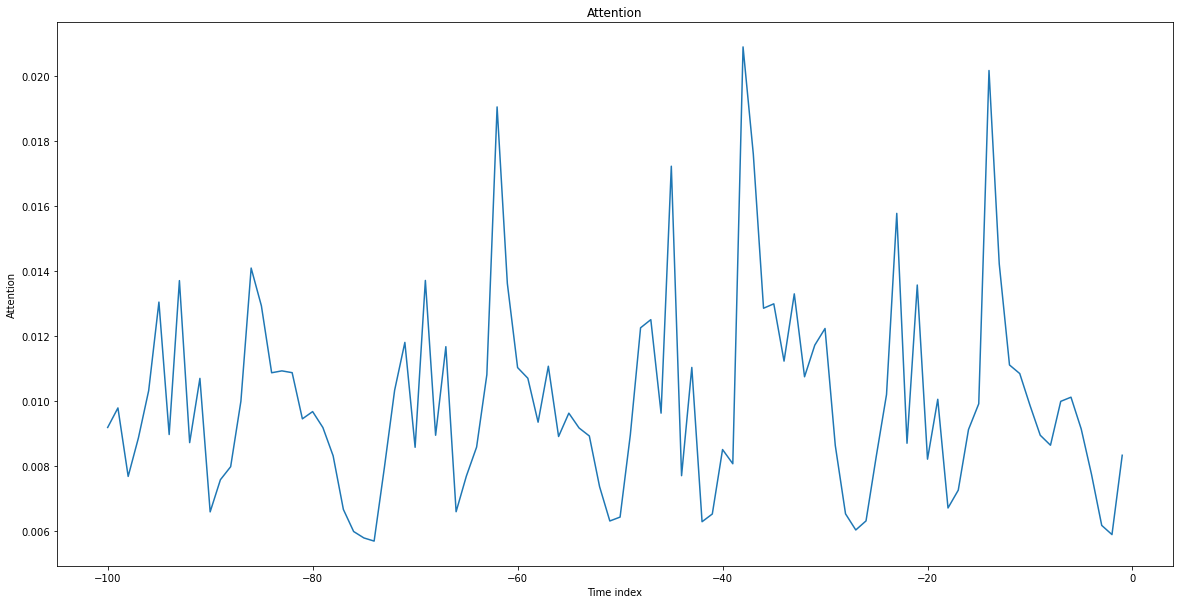

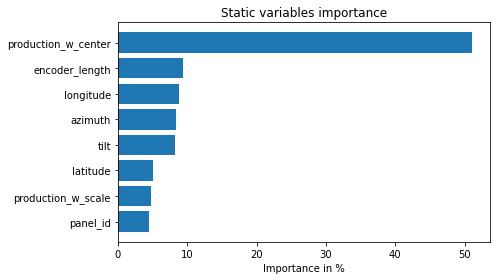

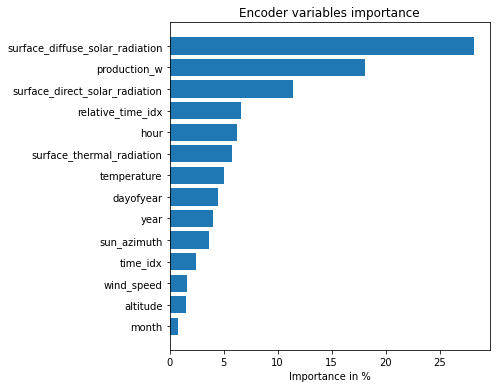

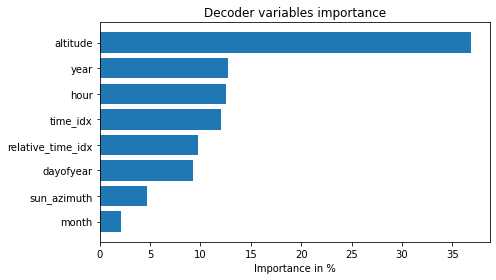

In [23]:
interpretation = best_tft.interpret_output(raw_predictions, reduction="sum")
best_tft.plot_interpretation(interpretation)

### (Optional) Optimalisation 

In [24]:
# find optimal learning rate
# res = trainer.tuner.lr_find(
#     tft,
#     train_dataloader=train_dataloader,
#     val_dataloaders=val_dataloader,
#     max_lr=10.0,
#     min_lr=1e-6,
# )

# print(f"suggested learning rate: {res.suggestion()}")
# fig = res.plot(show=True, suggest=True)
# fig.show()

In [25]:
# configure network and trainer
# pl.seed_everything(42) # randomization
# trainer = pl.Trainer(
#     gpus=0,
#     # clipping gradients is a hyperparameter and important to prevent divergance
#     # of the gradient for recurrent neural networks
#     gradient_clip_val=0.1,
# )


# tft = TemporalFusionTransformer.from_dataset(
#     training,
#     # not meaningful for finding the learning rate but otherwise very important
#     learning_rate=0.04,
#     hidden_size=16,  # most important hyperparameter apart from learning rate
#     # number of attention heads. Set to up to 4 for large datasets
#     attention_head_size=2,
#     dropout=0.1,  # between 0.1 and 0.3 are good values
#     hidden_continuous_size=8,  # set to <= hidden_size
#     output_size=7,  # 7 quantiles by default
#     loss=QuantileLoss(),
#     # reduce learning rate if no improvement in validation loss after x epochs
#     reduce_on_plateau_patience=4,
# )
# print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

In [26]:
#from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters

# create study
# study = optimize_hyperparameters(
#     train_dataloader,
#     val_dataloader,
#     model_path="optuna_test",
#     n_trials=200,
#     max_epochs=50,
#     gradient_clip_val_range=(0.01, 1.0),
#     hidden_size_range=(8, 128),
#     hidden_continuous_size_range=(8, 128),
#     attention_head_size_range=(1, 4),
#     learning_rate_range=(0.001, 0.1),
#     dropout_range=(0.1, 0.3),
#     trainer_kwargs=dict(limit_train_batches=30),
#     reduce_on_plateau_patience=4,
#     use_learning_rate_finder=False,  # use Optuna to find ideal learning rate or use in-built learning rate finder
# )

# save study results - also we can resume tuning at a later point in time
# with open("test_study.pkl", "wb") as fout:
#     pickle.dump(study, fout)

# show best hyperparameters
# print(study.best_trial.params)


In [27]:
# raw_prediction, x = best_tft.predict(
#     training.filter(lambda x: (x.agency == "Agency_01") & (x.sku == "SKU_01") & (x.time_idx_first_prediction == 15)),
#     mode="raw",
#     return_x=True,
# )
# best_tft.plot_prediction(x, raw_prediction, idx=0);
# raw_prediction

In [28]:
# PREDICTING ON DIFFERENT PART OF DATA (Encoder-decoder)

# select last 24 months from data (max_encoder_length is 24)
# encoder_data = data[lambda x: x.time_idx > x.time_idx.max() - max_encoder_length]

# # select last known data point and create decoder data from it by repeating it and incrementing the month
# # in a real world dataset, we should not just forward fill the covariates but specify them to account
# # for changes in special days and prices
# last_data = data[lambda x: x.time_idx == x.time_idx.max()]
# decoder_data = pd.concat(
#     [last_data.assign(date=lambda x: x.date + pd.offsets.MonthBegin(i)) for i in range(1, max_prediction_length + 1)],
#     ignore_index=True,
# )

# # add time index consistent with "data"
# decoder_data["time_idx"] = decoder_data["date"].dt.year * 12 + decoder_data["date"].dt.month
# decoder_data["time_idx"] += encoder_data["time_idx"].max() + 1 - decoder_data["time_idx"].min()

# # adjust additional time feature(s)
# decoder_data["month"] = decoder_data.date.dt.month.astype(str).astype("category")  # categories have be strings

# # combine encoder and decoder data
# new_prediction_data = pd.concat([encoder_data, decoder_data], ignore_index=True)

# new_raw_predictions, new_x = best_tft.predict(new_prediction_data, mode="raw", return_x=True)

# for idx in range(10):  # plot 10 examples
#     best_tft.plot_prediction(new_x, new_raw_predictions, idx=idx, show_future_observed=False);